# 0. Import Required Packages

In [ ]:
# !pip install tscv

In [1]:
import math
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import decomposition, datasets
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
import lightgbm as lgb
import pickle
import joblib
# from tscv import GapWalkForward
import gc
from tqdm import tqdm


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
import warnings
warnings.filterwarnings("ignore")

In [2]:
# For CV score calculation
def corr_score(pred, valid):
    len_data = len(pred)
    mean_pred = np.sum(pred) / len_data
    mean_valid = np.sum(valid) / len_data
    var_pred = np.sum(np.square(pred - mean_pred)) / len_data
    var_valid = np.sum(np.square(valid - mean_valid)) / len_data

    cov = np.sum((pred * valid))/len_data - mean_pred*mean_valid
    corr = cov / np.sqrt(var_pred * var_valid)

    return corr

# 1. Data Wrangling
## 1.1 Predictors

In [3]:
data = pd.read_csv('./research_dataset_2022.csv', parse_dates=True, index_col=0)
spy = pd.read_csv('./SPY.csv', parse_dates=True, index_col=0)
data.dropna(subset=['trans_spy_open'], inplace=True)

data['DEF'] = data['BAA'] - data['AAA']
data['TERM'] = data['US10YR'] - data['US3M']
data['VRP'] = data['trans_VIX'] - data['garch']
#data['PCR'] = data['trans_spy_open'] / data['trans_SPGSCI']
data['PCR'] = np.log(spy['Open']) / data['trans_SPGSCI']
# the current price versus the past 10 month simple moving average.
#data['MA'] = data['trans_spy_open'] / data['trans_spy_open'].rolling(217).mean()
data['MA'] = np.log(spy['Open'] / spy['Open'].rolling(217).mean())

In [4]:
# CAY
X = data[['Consumption_new', 'Income_new']][1800:]; Y = data['Assets_new'][1800:]
LR = LinearRegression().fit(X, Y)
residual = -(Y - LR.predict(X))
data['CAY'] = [np.nan] * 1800 + residual.to_list()

In [5]:
# MOM
data['MOM'] = np.nan
for i in range(len(spy)):
    data['MOM'] = np.log(spy['Open'] / spy['Open'].shift(-12))

In [6]:
# OBV
spy['OBV'] = np.nan
spy['OBV'].iloc[0] = spy.iloc[0]['Volume']
for i in range(1,len(spy)):
    if spy.iloc[i]['Close'] > spy.iloc[i-1]['Close']:
        spy['OBV'].iloc[i] = spy.iloc[i-1]['OBV'] + spy.iloc[i]['Volume']
    elif spy.iloc[i]['Close'] < spy.iloc[i-1]['Close']:
        spy['OBV'].iloc[i] = spy.iloc[i-1]['OBV'] - spy.iloc[i]['Volume']
    else:
        spy['OBV'].iloc[i] = spy.iloc[i-1]['OBV']
data['OBV'] = np.log(spy['OBV'])

In [7]:
data = data.reset_index().rename(columns={'index':'Date'})

In [8]:
data.head()

,Date,US3M,US10YR,trans_TRAIL_12M_EPS_BEF_XO_ITEM,trans_PE_RATIO,trans_PX_OPEN,trans_PX_HIGH,trans_PX_LOW,trans_PX_LAST,trans_SPGSCI,trans_BDIY,trans_VIX,trans_PCUSEQTR,trans_MVOLE,trans_SPXDIV,trans_LAST_DPS_GROSS,trans_DXY,trans_BFCIUS,CPI,NOS,ASPY,advDecl,FedFunds,trans_NYSEADV,CBOE_leadIC,BAA,NOS_exDef_exAir,BER,vintageCPI,DividendToPriceRatio,PxToBook,AAA,SI,urflag,fdtrflag,ppiflag,TRAIL_12M_EPS_BEF_XO_ITEM.vintage,realVol,loan_corrected,VVIX,NAPMNEWO,NAPMPRIC,NAPMPMI,IRX,delinquency,bbyield,spxhigh,spxlow,htime,ltime,spxopen,spxclose,otime,ctime,Consumption_new,Assets_new,Income_new,trans_TYVIX,trans_IAP,trans_EPUCNUSD,del.corona,garch,hulbert.pred,rv_5on,sentiment1,etf.sentiment,sentiment2,sentiment3,median_earnings,diff_earnings_yield,US2Y,MICH,ICSA,TOM,SIM,FOMC,w5kftr,FOMC_2Day,PCT_MEMBERS_WITH_NEW_52W_HIGHS,PCT_MEMBERS_WITH_NEW_52_WK_LOWS,htaassi,TOM48,com_tom,CAPE,CATY,IC,sentiment4,sentiment5,sentiment6,sentiment7,princomp_SentDir,IND_PROD,SOTU,vs3,w5kgdp,wil5kGDPnow,fed_cor,term_ret,vix_cor,trans_spy_open,trans_IEF,trans_SKEW,trans_SPVXMP,trans_SPVXSP,trans_VXO,trans_VXD,trans_VXN,trans_RVX,trans_VIX3M,trans_VIX6M,trans_VIX9D,trans_VIX1Y,ETS,sentiment8,DEF,TERM,VRP,PCR,MA,CAY,MOM,OBV
0,1993-02-02,3.019,6.432,0.243737,0.731277,3.096296,2.984301,3.046897,3.078541,-0.615948,0.212436,-1.284332,NaN,NaN,-0.348974,1.225766,1.471461,0.780383,142.3,-0.020431,26.110614,0.971987,3.18,0.993804,28.6607,8.51,-0.002053,3.450327,142.2,0.027932,2.5677,7.80,4.15,0,1,0,17.37,3.949745,4.4,NaN,61.0,48.0,54.2,2.96,5.01,0.007806,442.87,440.76,53820.0,35040.0,442.52,442.72,30660.0,54000.0,10.037544,11.763424,9.86984,NaN,NaN,-1.568178,5.01,0.004367,0.000350,4.338725,53.448277,NaN,40.740829,NaN,4.988235,83.901688,4.258,89.3,341000.0,1,1,1,NaN,1.0,11.8,1.6,NaN,0,1,20.604814,28.144472,NaN,NaN,NaN,NaN,NaN,NaN,611.075005,0,0.000013,0.489696,NaN,0.00047,0.000552,0.000442,11.291943,NaN,0.928510,NaN,NaN,-1.751606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.002856,73.85,0.71,3.413,-1.288699,-6.151734,NaN,NaN,0.018545,13.432492
1,1993-02-03,2.977,6.410,0.241726,0.927155,3.079280,3.490660,3.233196,3.591356,-0.586115,0.191510,-1.343845,NaN,NaN,-0.327310,-0.443492,1.529786,0.448815,142.3,-0.020431,26.386655,1.069448,3.56,2.134437,28.8966,8.53,-0.002053,3.436435,142.2,0.027316,2.5944,7.80,4.15,0,0,0,17.37,6.831445,4.4,NaN,61.0,48.0,54.2,2.93,5.01,0.007806,447.35,442.57,53400.0,30660.0,442.57,447.15,30660.0,54000.0,10.037544,11.763424,9.86984,NaN,NaN,-0.882129,5.01,0.004591,0.000477,7.458867,53.448277,NaN,40.740829,NaN,4.971963,83.045982,4.234,89.3,341000.0,0,1,0,NaN,1.0,19.0,1.2,NaN,0,1,20.824030,28.439578,NaN,NaN,NaN,NaN,NaN,NaN,611.075005,0,-0.000188,0.489696,NaN,0.00047,0.000552,0.000442,9.836422,NaN,1.118645,NaN,NaN,-1.351545,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.005646,74.05,0.73,3.433,-1.348435,-6.472072,NaN,NaN,0.016318,14.007122
2,1993-02-04,2.977,6.374,0.239752,1.024803,3.595321,3.742118,3.733281,3.815224,-0.420579,0.190455,-1.252104,NaN,NaN,-0.042461,3.702126,1.579223,0.335535,142.3,-0.020431,26.497059,1.141443,3.08,2.217918,28.8545,8.50,-0.001007,3.486284,142.2,0.027548,2.6070,7.77,4.15,1,0,0,17.37,4.992247,4.4,NaN,61.0,48.0,54.2,2.90,5.01,0.007806,449.86,447.24,53520.0,30660.0,447.24,449.46,30660.0,54000.0,10.037544,11.763424,9.86984,NaN,NaN,-0.990649,5.01,0.004481,0.000465,6.130609,60.344826,NaN,40.740829,NaN,4.925926,82.479088,4.176,89.3,340000.0,0,1,0,NaN,0.0,26.8,0.4,NaN,0,0,20.937127,28.589415,NaN,NaN,NaN,NaN,NaN,NaN,611.075005,0,-0.000097,0.489696,NaN,0.00047,0.000552,0.000442,10.141009,NaN,1.024942,NaN,NaN,-1.105538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.005885,68.64,0.73,3.397,-1.256585,-9.049357,NaN,NaN,0.025336,14.370946
3,1993-02-05,2.966,6.306,0.237814,0.992944,3.807645,3.654553,3.651068,3.690097,-0.471812,0.308287,-0.937690,NaN,NaN,0.008543,-0.048274,1.529539,0.386605,142.3,-0.020431,26.478629,1.129946,2.87,0.007456,28.6849,8.48,-0.001007,3.500176,142.2,0.027509,2.6047,7.74,4.15,0,0,0,17.37,5.755161,4.4,NaN,61.0,48.0,54.2,2.90,5.01,0.007806,449.56,446.95,306

In [9]:
var = data[['DividendToPriceRatio', 'trans_PE_RATIO', 'PxToBook', 'CAPE',
            'bbyield', 'DEF', 'TERM', 'CAY', 'SIM', 'VRP', 'IC', 'trans_BDIY',
            'NOS', 'CPI', 'PCR', 'MA', 'OBV', 'MOM', 'SI', 'trans_MVOLE', 
            'BER', 'NAPMPRIC', 'CATY', 'IND_PROD']]
var.rename(columns = {'DividendToPriceRatio':'DP', 'trans_PE_RATIO':'PE',
                      'PxToBook':'BM', 'bbyield':'BY', 'trans_BDIY':'BDI',
                      'trans_MVOLE':'MVOLE', 'IND_PROD':'IP'}, inplace = True)
# Replace NaN Values with Zeros
var = var.fillna(0)

In [10]:
data.head()

,Date,US3M,US10YR,trans_TRAIL_12M_EPS_BEF_XO_ITEM,trans_PE_RATIO,trans_PX_OPEN,trans_PX_HIGH,trans_PX_LOW,trans_PX_LAST,trans_SPGSCI,trans_BDIY,trans_VIX,trans_PCUSEQTR,trans_MVOLE,trans_SPXDIV,trans_LAST_DPS_GROSS,trans_DXY,trans_BFCIUS,CPI,NOS,ASPY,advDecl,FedFunds,trans_NYSEADV,CBOE_leadIC,BAA,NOS_exDef_exAir,BER,vintageCPI,DividendToPriceRatio,PxToBook,AAA,SI,urflag,fdtrflag,ppiflag,TRAIL_12M_EPS_BEF_XO_ITEM.vintage,realVol,loan_corrected,VVIX,NAPMNEWO,NAPMPRIC,NAPMPMI,IRX,delinquency,bbyield,spxhigh,spxlow,htime,ltime,spxopen,spxclose,otime,ctime,Consumption_new,Assets_new,Income_new,trans_TYVIX,trans_IAP,trans_EPUCNUSD,del.corona,garch,hulbert.pred,rv_5on,sentiment1,etf.sentiment,sentiment2,sentiment3,median_earnings,diff_earnings_yield,US2Y,MICH,ICSA,TOM,SIM,FOMC,w5kftr,FOMC_2Day,PCT_MEMBERS_WITH_NEW_52W_HIGHS,PCT_MEMBERS_WITH_NEW_52_WK_LOWS,htaassi,TOM48,com_tom,CAPE,CATY,IC,sentiment4,sentiment5,sentiment6,sentiment7,princomp_SentDir,IND_PROD,SOTU,vs3,w5kgdp,wil5kGDPnow,fed_cor,term_ret,vix_cor,trans_spy_open,trans_IEF,trans_SKEW,trans_SPVXMP,trans_SPVXSP,trans_VXO,trans_VXD,trans_VXN,trans_RVX,trans_VIX3M,trans_VIX6M,trans_VIX9D,trans_VIX1Y,ETS,sentiment8,DEF,TERM,VRP,PCR,MA,CAY,MOM,OBV
0,1993-02-02,3.019,6.432,0.243737,0.731277,3.096296,2.984301,3.046897,3.078541,-0.615948,0.212436,-1.284332,NaN,NaN,-0.348974,1.225766,1.471461,0.780383,142.3,-0.020431,26.110614,0.971987,3.18,0.993804,28.6607,8.51,-0.002053,3.450327,142.2,0.027932,2.5677,7.80,4.15,0,1,0,17.37,3.949745,4.4,NaN,61.0,48.0,54.2,2.96,5.01,0.007806,442.87,440.76,53820.0,35040.0,442.52,442.72,30660.0,54000.0,10.037544,11.763424,9.86984,NaN,NaN,-1.568178,5.01,0.004367,0.000350,4.338725,53.448277,NaN,40.740829,NaN,4.988235,83.901688,4.258,89.3,341000.0,1,1,1,NaN,1.0,11.8,1.6,NaN,0,1,20.604814,28.144472,NaN,NaN,NaN,NaN,NaN,NaN,611.075005,0,0.000013,0.489696,NaN,0.00047,0.000552,0.000442,11.291943,NaN,0.928510,NaN,NaN,-1.751606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.002856,73.85,0.71,3.413,-1.288699,-6.151734,NaN,NaN,0.018545,13.432492
1,1993-02-03,2.977,6.410,0.241726,0.927155,3.079280,3.490660,3.233196,3.591356,-0.586115,0.191510,-1.343845,NaN,NaN,-0.327310,-0.443492,1.529786,0.448815,142.3,-0.020431,26.386655,1.069448,3.56,2.134437,28.8966,8.53,-0.002053,3.436435,142.2,0.027316,2.5944,7.80,4.15,0,0,0,17.37,6.831445,4.4,NaN,61.0,48.0,54.2,2.93,5.01,0.007806,447.35,442.57,53400.0,30660.0,442.57,447.15,30660.0,54000.0,10.037544,11.763424,9.86984,NaN,NaN,-0.882129,5.01,0.004591,0.000477,7.458867,53.448277,NaN,40.740829,NaN,4.971963,83.045982,4.234,89.3,341000.0,0,1,0,NaN,1.0,19.0,1.2,NaN,0,1,20.824030,28.439578,NaN,NaN,NaN,NaN,NaN,NaN,611.075005,0,-0.000188,0.489696,NaN,0.00047,0.000552,0.000442,9.836422,NaN,1.118645,NaN,NaN,-1.351545,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.005646,74.05,0.73,3.433,-1.348435,-6.472072,NaN,NaN,0.016318,14.007122
2,1993-02-04,2.977,6.374,0.239752,1.024803,3.595321,3.742118,3.733281,3.815224,-0.420579,0.190455,-1.252104,NaN,NaN,-0.042461,3.702126,1.579223,0.335535,142.3,-0.020431,26.497059,1.141443,3.08,2.217918,28.8545,8.50,-0.001007,3.486284,142.2,0.027548,2.6070,7.77,4.15,1,0,0,17.37,4.992247,4.4,NaN,61.0,48.0,54.2,2.90,5.01,0.007806,449.86,447.24,53520.0,30660.0,447.24,449.46,30660.0,54000.0,10.037544,11.763424,9.86984,NaN,NaN,-0.990649,5.01,0.004481,0.000465,6.130609,60.344826,NaN,40.740829,NaN,4.925926,82.479088,4.176,89.3,340000.0,0,1,0,NaN,0.0,26.8,0.4,NaN,0,0,20.937127,28.589415,NaN,NaN,NaN,NaN,NaN,NaN,611.075005,0,-0.000097,0.489696,NaN,0.00047,0.000552,0.000442,10.141009,NaN,1.024942,NaN,NaN,-1.105538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.005885,68.64,0.73,3.397,-1.256585,-9.049357,NaN,NaN,0.025336,14.370946
3,1993-02-05,2.966,6.306,0.237814,0.992944,3.807645,3.654553,3.651068,3.690097,-0.471812,0.308287,-0.937690,NaN,NaN,0.008543,-0.048274,1.529539,0.386605,142.3,-0.020431,26.478629,1.129946,2.87,0.007456,28.6849,8.48,-0.001007,3.500176,142.2,0.027509,2.6047,7.74,4.15,0,0,0,17.37,5.755161,4.4,NaN,61.0,48.0,54.2,2.90,5.01,0.007806,449.56,446.95,306

## 1.2 Principle Component

In [11]:
std_slc = StandardScaler()
pca = decomposition.PCA(n_components=1)

# PCA_Price
X_price = var.loc[:, ['DP','PE','BM','CAPE']]
X_price_std = std_slc.fit_transform(X_price)
PCA_price = pca.fit_transform(X_price_std)
var.insert(loc=4, column='PCA_Price', value=PCA_price)

# PCA Tech
X_tech = var.loc[:, ['MA','OBV','MOM']]
X_tech_std = std_slc.fit_transform(X_tech)
PCA_tech = pca.fit_transform(X_tech_std)
var.insert(loc=19, column='PCA_Tech', value=PCA_tech)

var = var.drop(['DP','PE','BM','CAPE', 'MA','OBV','MOM'], axis=1)

## 1.3 Correlation between Predictors

<AxesSubplot:>

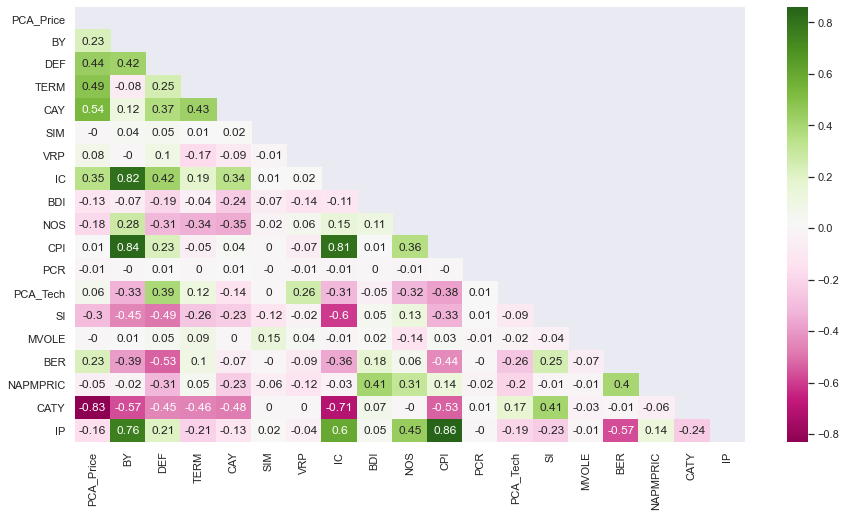

In [12]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(np.round(var.corr(), 2), mask=np.triu(np.ones_like(var.corr(), dtype=np.bool)), 
           cmap="PiYG", annot=True)

## 1.4 PCA to Aviod Multicollinearity

In [13]:
# PCA_Econ
X_econ = var.loc[:, ['BY','IC','CPI','IP']]
X_econ_std = std_slc.fit_transform(X_econ)
PCA_econ = pca.fit_transform(X_econ_std)
var.insert(loc=19, column='PCA_Econ', value=PCA_econ)

# new PCA_Price
var['DP'] = data['DividendToPriceRatio']; var['PE'] = data['trans_PE_RATIO']
var['BM'] = data['PxToBook']; var['CAPE'] = data['CAPE']
X_price_new = var.loc[:, ['DP','PE','BM','CAPE', 'CATY']]
X_price_new_std = std_slc.fit_transform(X_price_new)
PCA_price_new = pca.fit_transform(X_price_new_std)
var.insert(loc=1, column='PCA_Price_New', value=PCA_price_new)

var = var.drop(['BY','IC','CPI','IP', 'DP','PE','BM','CAPE', 'CATY', 'PCA_Price'], axis=1)

<AxesSubplot:>

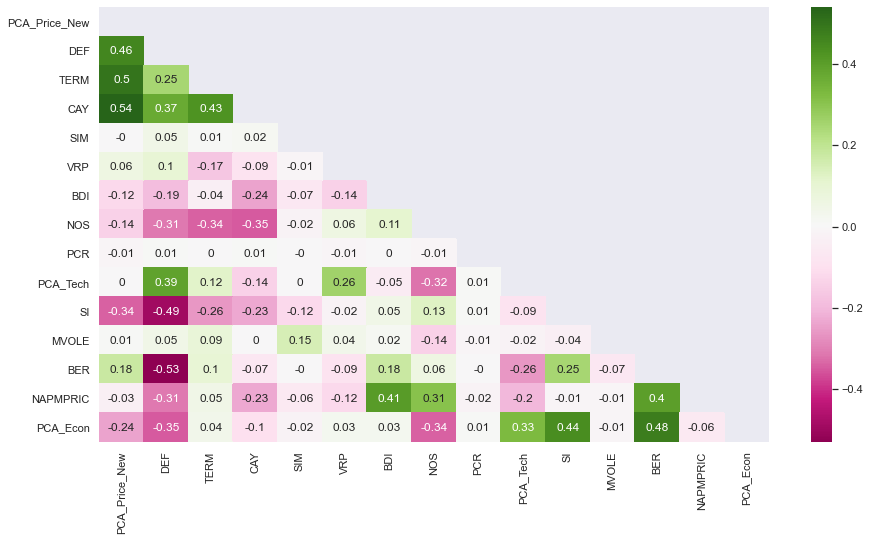

In [14]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(np.round(var.corr(), 2), mask=np.triu(np.ones_like(var.corr(), dtype=np.bool)), 
           cmap="PiYG", annot=True)

In [15]:
data_ori = pd.concat([data['Date'], var], axis=1)

## 1.5 Extra Features Processing

In [16]:
# -*- coding: utf-8 -*-
# Create new features
import pandas as pd
import numpy as np
import time

class FeatureWorkerClass(object):
    def __init__(self, target_code):
        self.target_col = target_code
        
    # define function to compute log returns
#     @staticmethod
#     def create_log_return(df, target_col, periods=1):
#         return_df = df.copy()
# #         return_df['log_return'] = np.log(return_df[target_col]).diff(periods=periods).shift(-1)
#         return_df['log_return'] = return_df[target_col].diff(periods=periods).shift(-1)
# #         return_df['log_return'] = return_df[target_col].diff(periods=periods)
#         return return_df
#     @staticmethod
#     def create_log_return(df, target_col, days=7, periods=1):
#         return_df = df.copy()
# #         return_df['log_return'] = np.log(return_df[target_col]).diff(periods=periods).shift(-1)
#         return_df['log_return'] = np.log(return_df[target_col] / return_df[target_col].shift(-days))
# #         return_df['log_return'] = return_df[target_col].diff(periods=periods)
#         return return_df
    @staticmethod
    def create_return(df, target_col, days=130, periods=1):
        return_df = df.copy()
#         return_df['log_return'] = np.log(return_df[target_col]).diff(periods=periods).shift(-1)
        return_df[f'{days}_return'] = (return_df[target_col].shift(-days) - return_df[target_col]) / return_df[target_col]
#         return_df['log_return'] = return_df[target_col].diff(periods=periods)
        return return_df
    
    # create log_close/mean features
    @staticmethod
    def create_log_close_mean_features(df, target_col, lags=[2, 3, 5, 10, 20, 30]):
        lcm_df = df.copy()
        for lag in lags:
            lcm_df[f'log_close/mean_{lag}'] = np.log( np.array(lcm_df[target_col]) \
                                                     / np.roll(np.append(np.convolve( np.array(lcm_df[target_col]), \
                                                                                     np.ones(lag)/lag, mode="valid"), np.ones(lag-1)), lag-1))
            
            lcm_df[f'log_return_{lag}'] = np.log(np.array(lcm_df[target_col]) \
                                                    /  np.roll(np.array(lcm_df[target_col]), lag))
        return lcm_df

    # create lag features
    @staticmethod
    def create_lag_features(df, target_col, lags):
        lag_df = df.copy()
        for i in lags:
            lag_df[f'{target_col}_lag_{i}'] = lag_df[target_col].shift(i).values
        return lag_df

    # create rolling features: mean, max, min, median, std
    @staticmethod
    def create_rolling_features(df, target_col, windows, min_periods=1, shift=1):
        rolling_shift_df = df.copy()
        for w in windows:
            shift_df = rolling_shift_df[target_col].shift(shift).rolling(
                window=w, 
                min_periods=min_periods
                ).agg([ 'max', 'mean', 'min', 'median', np.nanstd], axis=1
                ).rename(columns={
                        'max': "_rmax_{}".format(w),
                        'mean': "_rmean_{}".format(w),
                        'min': "_rmin_{}".format(w),
                        'median': "_rmedian_{}".format(w),
                        'nanstd': "_rstd_{}".format(w),
                        }).reset_index()
            shift_df.columns = [''.join(col) for col in shift_df.columns]
            del shift_df['index']
            rolling_shift_df[list(shift_df.columns)] = shift_df
            
        return rolling_shift_df

    # create rolling skew features
    @staticmethod
    def create_rskew_features(df, target_col, windows, min_periods=2, shift=1):
        rolling_rskew_df = df.copy()
        for w in windows:
            rolling_rskew_df[f'{target_col}_rskew_{w}'] = \
                rolling_rskew_df[target_col].shift(shift).rolling(
                    window=w,
                    min_periods=min_periods
                ).skew().fillna(0).values
        return rolling_rskew_df

    # create diff features
    @staticmethod
    def create_diff_features(df, target_col, periods=[1], shift=1):
        diff_df = df.copy()
        for p in periods:
            diff_df[f'{target_col}_diff_{p}'] = \
                diff_df[target_col].shift(shift).diff(periods=p).abs().values
        return diff_df

    # create percentage change features
    @staticmethod
    def create_pct_change_features(df, target_col, periods=[1], shift=1):
        pct_change_df = df.copy()
        for p in periods:
            pct_change_df[f'{target_col}_pct_change_{p}'] = \
                pct_change_df[target_col].shift(shift).pct_change(periods=p).replace(np.inf,0).fillna(0).abs().values
        return pct_change_df

    # Creating exponentially weighted mean features
    @staticmethod
    def create_ewm_features(df, target_col, alpha=[0.9], shift=[1]):
        ewm_df = df.copy()
        for a in alpha:
            for s in shift:
                ewm_df[f'{target_col}_ewm_{a}_{s}'] = \
                    ewm_df[target_col].shift(s).ewm(alpha=a).mean().values
        return ewm_df
    
    @staticmethod
    def create_kdj_features(df, target_col, min_periods=2, windows=[10], com=[2], shift=1):
        kdj_df = df.copy()
        for c in com:
            for w in windows:
                lowest = kdj_df[target_col].shift(shift).rolling(window=w, min_periods=min_periods).min()
                highest = kdj_df[target_col].shift(shift).rolling(window=w, min_periods=min_periods).max()
                rsv = (kdj_df[target_col].shift(shift) - lowest) / (highest - lowest) * 100
                rsv.fillna(value = 100.0, inplace=True)

                k = rsv.ewm(com=c, adjust=False).mean()
                kdj_df[f'{target_col}_kdj_{c}_{w}'] = 3 * k - 2 * k.ewm(com=c, adjust=False).mean()
        return kdj_df
    
    @staticmethod
    def create_normal_features(df):
        n_df = df.copy()
        n_df['Upper_Shadow'] = n_df['High'] - np.maximum(n_df['Close'], n_df['Open'])
        n_df['Lower_Shadow'] = np.minimum(n_df['Close'], n_df['Open']) - n_df['Low']
        # n_df['hlco_ratio'] = (n_df['High'] - n_df['Low'])/(n_df['Close'] - n_df['Open']+1)
        return n_df
        
    def create_origin_features(self, df):
        matrix_df = df.copy()
        
        matrix = self.create_lag_features(df=matrix_df,
                                                    target_col=self.target_col,
                                                    lags=[1])
        print("lag feature over.......................") 
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))
        
        
    def create_return_features(self, df):
        matrix_df = df.copy()
        
        matrix_df = self.create_return(df=matrix_df,
                                            target_col=self.target_col
                                                       )
        print("return feature over.......................")
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))
        
        
        return matrix_df
        
        
    
    def create_lag_return_features(self, df):
        matrix_df = df.copy()
        
        
        matrix_df = self.create_lag_features(df=matrix_df,
                                             target_col=self.target_col,
                                             lags=[1,2,3,4,5,6,7])
        print("lag feature over.......................") 
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))

 
        matrix_df = self.create_rolling_features(df=matrix_df,
                                                    target_col=self.target_col,
                                                    shift=0,
                                                    windows=[2, 3, 4, 8, 12, 16, 30])
        print("rolling feature over.......................")
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))
        
        matrix_df = self.create_log_close_mean_features(df=matrix_df,
                                                    target_col=self.target_col,
                                                    lags=[2, 3, 5, 10, 20, 30]
                                                       )
        print("log_close_mean feature over.......................")
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))

        matrix_df = self.create_pct_change_features(df=matrix_df,
                                                    target_col=self.target_col,
                                                    shift=0,
                                                    periods=[1, 2, 3, 4, 8, 12, 16, 30])
        print("pct change feature over.......................")
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))


        matrix_df = self.create_ewm_features(df=matrix_df,
                                             target_col=self.target_col,
                                             alpha=[0.8, 0.5],
                                             shift=[3, 4, 8, 12, 16, 30])
        print("ewm feature over.......................")
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))
        
        matrix_df = self.create_rskew_features(df=matrix_df,
                                             target_col=self.target_col,
                                             windows=[4, 8, 12, 16, 48], 
                                             min_periods=2, 
                                             shift=0)
        print("rskew feature over.......................")
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))
        
        matrix_df = self.create_kdj_features(df=matrix_df,
                                             target_col=self.target_col,
                                             min_periods=2, 
                                             windows=[7, 10, 20, 30], 
                                             com=[1, 2],
                                             shift=0)
        print("kdj feature over.......................")
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))
        
        return matrix_df

##### lag features

- Params: lag days

- The return value of N day before.

##### Rolling features
- Params: windows
- max/min/mean/std of past N days' return

#### log_close_mean features

- Params: periods

- log_close_mean_period = $\frac{log(Close_t)}{mean(Close_{t-period,t})}$
- log_return_period = $log(Close_t) - log(Close_{t-period})$



#### PCT change features

- Params: periods
- pct_change_period = $\frac{Close_t-Close_{t-period}}{Close_{t-period}}$


#### EWM features

- Params: shift, alpha
- ewm_alpha_shift = $\frac{Close_{t-shift}+(1-\alpha)Close_{t-shift-1}+(1-\alpha)^2Close_{t-shift-2}+...+(1-\alpha)^{t-shift}Close_0}{1+(1-\alpha)+(1-\alpha)^2+...+(1-\alpha)^{t-shift}}$

#### rskew features
- Params: windows
- return the rolling skew from $Close_t$ to $Close_{t-window}$ 


#### KDJ features
- Params: com, windows
- $RSV_t = \frac{Close_t-Lowest_t}{Highest_t-lowest_t}*100$
- $K_t = (1-\frac{1}{1+com})K_{t-1}+\frac{1}{1+com}RSV_t$

In [17]:
spy = pd.read_csv('./SPY.csv', parse_dates=True, index_col=0)
spy = spy.reset_index()

In [18]:
spy_log = FeatureWorkerClass('Close').create_return_features(spy.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)).drop(['Close'], axis=1)
spy_log['year'] = spy_log['Date'].apply(lambda x: int(str(x)[0:4]))
spy_log['month'] = spy_log['Date'].apply(lambda x: int(str(x)[5:7]))
spy_log['day'] = spy_log['Date'].apply(lambda x: int(str(x)[8:10]))

return feature over.......................
2022-07-24 16:01:17


Drop last 130 days.

In [19]:
spy_log = spy_log.iloc[:-130, :]

In [20]:
spy_log.tail()

,Date,130_return,year,month,day
7174,2021-07-28,0.032177,2021,7,28
7175,2021-07-29,0.037899,2021,7,29
7176,2021-07-30,0.018449,2021,7,30
7177,2021-08-02,0.025389,2021,8,2
7178,2021-08-03,0.013850,2021,8,3


Create upper shadow and lower shadow features

In [21]:
matrix_df = FeatureWorkerClass('Close').create_normal_features(spy)

Create extra features on 'Close'

In [22]:
matrix_df = FeatureWorkerClass('Close').create_lag_return_features(matrix_df).drop(['Open', 'High', 'Low', 'Close'], axis=1)

lag feature over.......................
2022-07-24 16:01:17
rolling feature over.......................
2022-07-24 16:01:17
log_close_mean feature over.......................
2022-07-24 16:01:17
pct change feature over.......................
2022-07-24 16:01:17
ewm feature over.......................
2022-07-24 16:01:17
rskew feature over.......................
2022-07-24 16:01:17
kdj feature over.......................
2022-07-24 16:01:17


In [23]:
matrix_df.tail()

,Date,Adj Close,Volume,Upper_Shadow,Lower_Shadow,Close_lag_1,Close_lag_2,Close_lag_3,Close_lag_4,Close_lag_5,Close_lag_6,Close_lag_7,_rmax_2,_rmean_2,_rmin_2,_rmedian_2,_rstd_2,_rmax_3,_rmean_3,_rmin_3,_rmedian_3,_rstd_3,_rmax_4,_rmean_4,_rmin_4,_rmedian_4,_rstd_4,_rmax_8,_rmean_8,_rmin_8,_rmedian_8,_rstd_8,_rmax_12,_rmean_12,_rmin_12,_rmedian_12,_rstd_12,_rmax_16,_rmean_16,_rmin_16,_rmedian_16,_rstd_16,_rmax_30,_rmean_30,_rmin_30,_rmedian_30,_rstd_30,log_close/mean_2,log_return_2,log_close/mean_3,log_return_3,log_close/mean_5,log_return_5,log_close/mean_10,log_return_10,log_close/mean_20,log_return_20,log_close/mean_30,log_return_30,Close_pct_change_1,Close_pct_change_2,Close_pct_change_3,Close_pct_change_4,Close_pct_change_8,Close_pct_change_12,Close_pct_change_16,Close_pct_change_30,Close_ewm_0.8_3,Close_ewm_0.8_4,Close_ewm_0.8_8,Close_ewm_0.8_12,Close_ewm_0.8_16,Close_ewm_0.8_30,Close_ewm_0.5_3,Close_ewm_0.5_4,Close_ewm_0.5_8,Close_ewm_0.5_12,Close_ewm_0.5_16,Close_ewm_0.5_30,Close_rskew_4,Close_rskew_8,Close_rskew_12,Close_rskew_16,Close_rskew_48,Close_kdj_1_7,Close_kdj_1_10,Close_kdj_1_20,Close_kdj_1_30,Close_kdj_2_7,Close_kdj_2_10,Close_kdj_2_20,Close_kdj_2_30
7304,2022-02-01,449.605042,123155400,0.679993,3.739991,449.910004,441.950012,431.239990,433.380005,434.470001,439.839996,437.980011,452.950012,451.430008,449.910004,451.430008,2.149610,452.950012,448.270009,441.950012,449.910004,5.680421,452.950012,444.012504,431.239990,445.930008,9.696229,452.950012,440.215004,431.23999,438.910004,7.788202,464.720001,445.119168,431.23999,444.350006,10.344586,471.019989,450.765001,431.23999,450.830002,13.508529,477.709991,460.299001,431.23999,465.115005,14.936822,0.003361,0.024585,0.010386,0.049117,0.024730,0.041655,0.024422,-0.007785,-0.003658,-0.053222,-0.016095,-0.015162,0.006757,0.024890,0.050343,0.045157,0.013878,0.024928,0.028192,0.015048,431.754785,433.813967,448.007080,465.744942,466.550425,461.300300,433.563505,435.887020,451.612277,467.096449,468.213234,463.552394,-0.858122,0.701084,0.378911,0.083903,-0.868687,124.729554,118.259472,56.512203,56.329542,123.397893,108.318747,50.357169,49.883177
7305,2022-02-02,453.972565,117361000,0.769989,2.450012,452.950012,449.910004,441.950012,431.239990,433.380005,434.470001,439.839996,457.350006,455.150009,452.950012,455.150009,3.111266,457.350006,453.403341,449.910004,452.950012,3.740660,457.350006,450.540008,441.950012,451.430008,6.490227,457.350006,442.636253,431.23999,440.895004,9.756362,457.350006,444.505002,431.23999,444.350006,9.234271,471.019989,450.255001,431.23999,450.830002,13.061370,477.709991,460.378001,431.23999,465.115005,14.913970,0.004822,0.016401,0.008667,0.034252,0.023607,0.053834,0.032823,0.012320,0.008233,-0.043220,-0.006599,0.005195,0.009714,0.016537,0.034846,0.060546,0.044226,0.015859,0.017529,0.005209,439.910967,431.754785,439.985425,464.924989,465.718093,456.244069,437.756759,433.563505,444.796144,465.908225,466.861622,459.266202,-0.741975,0.374824,-0.017302,0.126913,-0.821811,120.519463,122.863649,75.678041,66.176814,130.638751,125.618839,71.844493,64.179182
7306,2022-02-03,443.301941,118024400,2.019989,0.890015,457.350006,452.950012,449.910004,441.950012,431.239990,433.380005,434.470001,457.350006,451.975006,446.600006,451.975006,7.601398,457.350006,452.300008,446.600006,452.950012,5.404397,457.350006,451.702507,446.600006,451.430008,4.571619,457.350006,443.481255,431.23999,444.275009,9.772310,457.350006,443.680837,431.23999,444.275009,8.477712,471.019989,448.808126,431.23999,448.330002,11.996665,477.709991,459.829334,431.23999,465.115005,15.113340,-0.011964,-0.014118,-0.012682,-0.007384,-0.007033,0.034999,0.009071,-0.000336,-0.013149,-0.047617,-0.029192,-0.036193,0.023505,0.014019,0.007357,0.010522,0.015369,0.021665,0.049282,0.035546,447.910197,439.910967,439.869082,458.176990,468.943619,461.696812,443.833381,437.756759,442.318070,461.199108,468.305811,461.163100,0.303231,0.043305,0.022241,0.250328,-0.721912,73.165135,77.126841,50.935370,43.007930,98.42998

In [24]:
data_ori.tail()

,Date,PCA_Price_New,DEF,TERM,CAY,SIM,VRP,BDI,NOS,PCR,PCA_Tech,SI,MVOLE,BER,NAPMPRIC,PCA_Econ
7304,2022-02-02,-2.527231,0.68,1.5900,-0.1248,1,0.260503,-1.247980,0.04485,2.162632,-0.504007,3.543710,-1.014133,2.4272,76.1,-2.196593
7305,2022-02-03,-2.258122,0.57,1.6404,-0.1248,1,0.683729,-1.225233,0.04485,2.096109,-0.415408,3.553919,-0.792912,2.4083,76.1,-2.196593
7306,2022-02-04,-2.275808,0.52,1.6853,-0.1248,1,0.465799,-1.210591,0.04485,1.969693,-0.327882,3.492266,-0.788274,2.4119,76.1,-2.196593
7307,2022-02-07,-2.240460,0.65,1.7054,-0.1248,1,0.395275,-1.195652,0.04485,2.047572,-0.380284,3.456699,-0.908974,2.4102,76.1,-2.196593
7308,2022-02-08,-2.322516,0.65,1.6983,-0.1248,1,0.151261,-1.107975,0.04485,0.000000,1.905152,3.412222,-0.946572,2.4288,76.1,-2.195656


Merge all data together on 'Date'

In [25]:
mg = pd.merge(data_ori, spy_log, on=['Date'])
mg = pd.merge(mg, matrix_df, on=['Date'])
# mg = pd.merge(matrix_df, spy_log, on=['Date'])

In [26]:
# sorted(mg.corr()['130_return'].items(), key=lambda x: abs(x[1]), reverse=True)

In [27]:
mg.tail()

,Date,PCA_Price_New,DEF,TERM,CAY,SIM,VRP,BDI,NOS,PCR,PCA_Tech,SI,MVOLE,BER,NAPMPRIC,PCA_Econ,130_return,year,month,day,Adj Close,Volume,Upper_Shadow,Lower_Shadow,Close_lag_1,Close_lag_2,Close_lag_3,Close_lag_4,Close_lag_5,Close_lag_6,Close_lag_7,_rmax_2,_rmean_2,_rmin_2,_rmedian_2,_rstd_2,_rmax_3,_rmean_3,_rmin_3,_rmedian_3,_rstd_3,_rmax_4,_rmean_4,_rmin_4,_rmedian_4,_rstd_4,_rmax_8,_rmean_8,_rmin_8,_rmedian_8,_rstd_8,_rmax_12,_rmean_12,_rmin_12,_rmedian_12,_rstd_12,_rmax_16,_rmean_16,_rmin_16,_rmedian_16,_rstd_16,_rmax_30,_rmean_30,_rmin_30,_rmedian_30,_rstd_30,log_close/mean_2,log_return_2,log_close/mean_3,log_return_3,log_close/mean_5,log_return_5,log_close/mean_10,log_return_10,log_close/mean_20,log_return_20,log_close/mean_30,log_return_30,Close_pct_change_1,Close_pct_change_2,Close_pct_change_3,Close_pct_change_4,Close_pct_change_8,Close_pct_change_12,Close_pct_change_16,Close_pct_change_30,Close_ewm_0.8_3,Close_ewm_0.8_4,Close_ewm_0.8_8,Close_ewm_0.8_12,Close_ewm_0.8_16,Close_ewm_0.8_30,Close_ewm_0.5_3,Close_ewm_0.5_4,Close_ewm_0.5_8,Close_ewm_0.5_12,Close_ewm_0.5_16,Close_ewm_0.5_30,Close_rskew_4,Close_rskew_8,Close_rskew_12,Close_rskew_16,Close_rskew_48,Close_kdj_1_7,Close_kdj_1_10,Close_kdj_1_20,Close_kdj_1_30,Close_kdj_2_7,Close_kdj_2_10,Close_kdj_2_20,Close_kdj_2_30
7173,2021-07-28,-2.729715,0.68,1.1871,-0.129567,0,-0.504919,1.767320,0.04485,3.939787,-1.287806,4.679348,-0.265969,2.4107,92.1,-1.974580,0.032177,2021,7,28,432.678192,52472400,0.619995,1.519989,439.010010,441.019989,439.940002,435.459991,434.549988,431.059998,424.970001,439.010010,438.919998,438.829987,438.919999,0.127295,441.019989,439.619995,438.829987,439.010010,1.215767,441.019989,439.699997,438.829987,439.475006,1.005482,441.019989,435.604996,424.970001,437.144989,5.411671,441.019989,435.229996,424.970001,435.524993,4.498894,441.019989,435.046246,424.970001,435.489990,4.039601,441.019989,430.610996,414.920013,431.199997,6.577091,-0.000205,-0.004978,-0.001799,-0.002526,-0.000050,0.009801,0.008552,0.005920,0.010390,0.025690,0.018907,0.033247,0.000410,0.004966,0.002523,0.007739,0.017364,0.004004,0.013628,0.033806,438.972210,435.101044,432.078028,436.609871,432.936704,424.589466,436.916789,433.893576,433.327337,435.447450,432.139337,424.431307,0.870102,-1.183392,-0.972206,-0.867581,0.287094,81.000640,89.963718,88.048964,93.004378,92.193201,98.592831,92.997692,96.843659
7174,2021-07-29,-2.849275,0.71,1.2262,-0.137207,0,-0.597260,1.862212,0.04485,3.608268,-1.275167,4.699814,-0.380583,2.4185,92.1,-1.974533,0.037899,2021,7,29,434.472687,47435300,1.149994,0.010009,438.829987,439.010010,441.019989,439.940002,435.459991,434.549988,431.059998,440.649994,439.739990,438.829987,439.739991,1.286939,440.649994,439.496664,438.829987,439.010010,1.002861,441.019989,439.877495,438.829987,439.830002,1.118310,441.019989,437.564995,431.059998,438.919999,3.517699,441.019989,435.651662,424.970001,435.849990,4.764963,441.019989,435.433121,424.970001,435.554992,4.269576,441.019989,431.228997,414.920013,432.134994,6.621653,0.002067,0.003729,0.002621,-0.000839,0.001726,0.011848,0.011336,0.013480,0.013081,0.028988,0.021612,0.042985,0.004147,0.003736,0.000839,0.001614,0.036897,0.011616,0.014248,0.043922,440.610433,438.972210,426.391606,435.793971,434.155334,422.605881,438.968389,436.916789,429.148669,435.518723,433.299664,423.270646,0.071535,-0.975612,-0.977251,-0.873924,0.285407,92.575481,98.527877,97.382058,98.593663,97.641658,103.586527,98.940102,100.282825
7175,2021-07-30,-2.704185,0.71,1.1817,-0.138551,0,-0.510827,1.987002,0.04485,3.719893,-1.236120,4.758349,-0.288045,2.4003,92.1,-2.017324,0.018449,2021,7,30,432.362732,68951200,1.549988,0.140015,440.649994,438.829987,439.010010,441.019989,439.940002,435.459991,434.549988,440.649994,439.580002,438.510010,439.580002,1.513197,440.649994,439.329997,438.510010,438.829987,1.154292,440.649994,439.250000,438.510010,438.919999,0.955959,441.019989,438.496246,434.549988,438.919999,2.337876,441.019989,435.840830,424.970001,436.985000,4.

In [28]:
df = mg.copy()

X = df.iloc[30:].drop(['130_return'], axis=1)
y = df.iloc[30:][['130_return']]

## 2. Training

In [29]:
# define features for LGBM
not_use_features_train = ['Date']

features = X.columns 
features = features.drop(not_use_features_train)
features = list(features)
# display(features)  
len(features)

109

### 2.1 LGBM

Plot lightgbm-cv-feature-importance

In [30]:
# from: https://blog.amedama.jp/entry/lightgbm-cv-feature-importance
def plot_importance(importances, features_names = features, PLOT_TOP_N = 20, figsize=(10, 10)):
    importance_df = pd.DataFrame(data=importances, columns=features)
    sorted_indices = importance_df.median(axis=0).sort_values(ascending=False).index
    sorted_importance_df = importance_df.loc[:, sorted_indices]
    plot_cols = sorted_importance_df.columns[:PLOT_TOP_N]
    _, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.set_xscale('log')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    sns.boxplot(data=sorted_importance_df[plot_cols],
                orient='h',
                ax=ax)
    plt.show()

LGBM CV

In [31]:
def kf_lgbm(F, X_train, y_train):
    seed0 = 0
    params = {
        'early_stopping_rounds': 50,
        'objective': 'regression',
        'metric': 'rmse',
    #     'metric': 'None',
        'boosting_type': 'gbdt',
        'max_depth': 5,
        'verbose': -1,
        'max_bin':600,
        'min_data_in_leaf':50,
        'learning_rate': 0.03,
        'subsample': 0.8,
        'subsample_freq': 1,
        'feature_fraction': 1,
        'lambda_l1': 0.5,
        'lambda_l2': 1,
        'seed':seed0,
        'feature_fraction_seed': seed0,
        'bagging_fraction_seed': seed0,
        'drop_seed': seed0,
        'data_random_seed': seed0,
        'extra_trees': True,
        'extra_seed': seed0,
        'zero_as_missing': True,
        "first_metric_only": True,
#         "device": "gpu",
#         "gpu_platform_id": 0,
#         "gpu_device_id": 0,
             }
    fold = F
    # cv = GapWalkForward(n_splits=fold, gap_size=100, test_size=22)
    cv = KFold(n_splits = fold, random_state = 2021, shuffle = True)
    importances = []
    oof_pred = []
    oof_valid = []
    for split, train_test_split in enumerate(cv.split(X_train)):
        gc.collect()
        train_index, val_index = train_test_split
    #     train_X, train_Y = X_train.iloc[train_index, :].copy(), y_train.iloc[train_index, :].copy()
    #     val_X, val_Y = X_train.iloc[val_index, :].copy(), y_train.iloc[val_index, :].copy()
    #     print(train_X.tail())
        train_dataset = lgb.Dataset(X_train.iloc[train_index, 1:],
                                        y_train.iloc[train_index, :].values, 
                                        feature_name = features, 
                                       )
        val_dataset = lgb.Dataset(X_train.iloc[val_index, 1:], 
                                      y_train.iloc[val_index, :].values, 
                                      feature_name = features, 
                                     )
        print(f"number of train data: {len(X_train.iloc[train_index])}")
        print(f"number of val data:   {len(X_train.iloc[val_index])}")
        model = lgb.train(params = params,
                              train_set = train_dataset, 
                              valid_sets=[train_dataset, val_dataset],
                              valid_names=['tr', 'vl'],
                              num_boost_round = 10000,
                              verbose_eval = 2000,     
    #                           feval = rmse,
                             )
        importances.append(model.feature_importance(importance_type='gain'))
        file = f'trained_model_fold{split}.pkl'
        pickle.dump(model, open(file, 'wb'))
        print(f"Trained model was saved to 'trained_model_fold{split}.pkl'")
        print("")

#         oof_pred += list(model.predict(X_train.iloc[val_index, 1:]))
#         oof_valid += list(y_train.iloc[val_index, :].values)


#     plot_importance(np.array(importances),features, PLOT_TOP_N = 20, figsize=(10, 5))
    return model



In [32]:
def rolling_predict(X, y, tr_num, test_num):
    all_pred = list()
    all_y = list()
    for i in tqdm(range(int(len(X.iloc[tr_num:])/test_num))):
        print('Train data num: {}'.format(tr_num))
        print('Test data num: {}'.format(test_num))
        num = i * test_num
        train_X = X.iloc[num:tr_num+num]
        train_y = y.iloc[num:tr_num+num]
        test_X = X.iloc[tr_num+num:tr_num+num+test_num]
        test_y = y.iloc[tr_num+num:tr_num+num+test_num]
#         print(test_X.head())
        if num % 30 == 0:
            fold = 5
            kf_lgbm(fold, train_X, train_y)
        pred = []
        for i in range(fold):
            model = joblib.load(f"./trained_model_fold{i}.pkl")
            pred.append(model.predict(test_X.iloc[:, 1:]))
        y_pred = np.mean(pred, axis=0)
        
        all_pred += list(y_pred)
        all_y += list(test_y.values)
    return all_pred, all_y
        
    
    

In [ ]:
all_pred, all_y = rolling_predict(X, y, 2600, 1)

In [62]:
# all_pred = pd.read_csv('./lgbm_pred.csv')['lgbm_pred']
# all_y = y.iloc[2600:7256]
# all_pred.index = all_y.index
# all_y = all_y.values

lgbm rmse: 0.004507974907238488
lgbm r sqaure: 0.6205593231357102


<AxesSubplot:xlabel='Date', ylabel='value'>

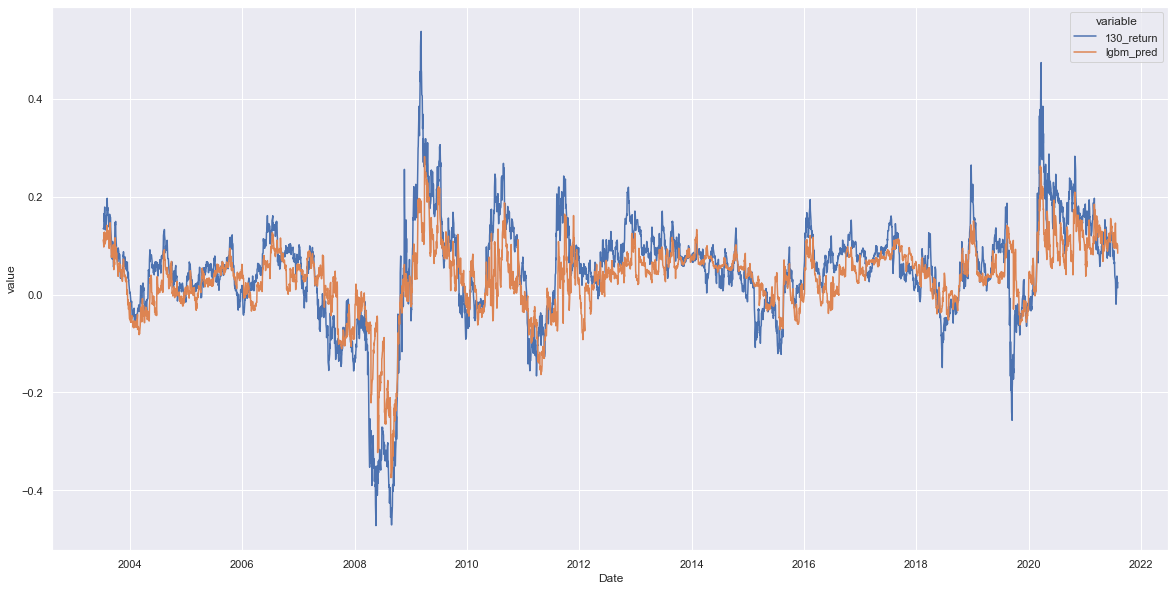

In [63]:
tmp = y.iloc[2600:7256].copy()
# tmp.rename()
# tmp = pd.DataFrame()
# tmp['22_return'] = list(y.iloc[6000:7254].values)
tmp['Date'] = X.iloc[2600:]['Date']
try:
    tmp['lgbm_pred'] = all_pred
except:
    tmp['lgbm_pred'] = all_pred['lgbm_pred']
lgbm_rmse = mse(all_y, all_pred)
lgbm_r2 = r2_score(all_y, all_pred)
print('lgbm rmse: {}'.format(lgbm_rmse))
print('lgbm r sqaure: {}'.format(lgbm_r2))
ml = pd.melt(tmp, id_vars=['Date'])
plt.figure(figsize=(20, 10))
sns.lineplot(data=ml, x='Date', y='value', hue='variable')

### CV LGBM feature importance boxplot

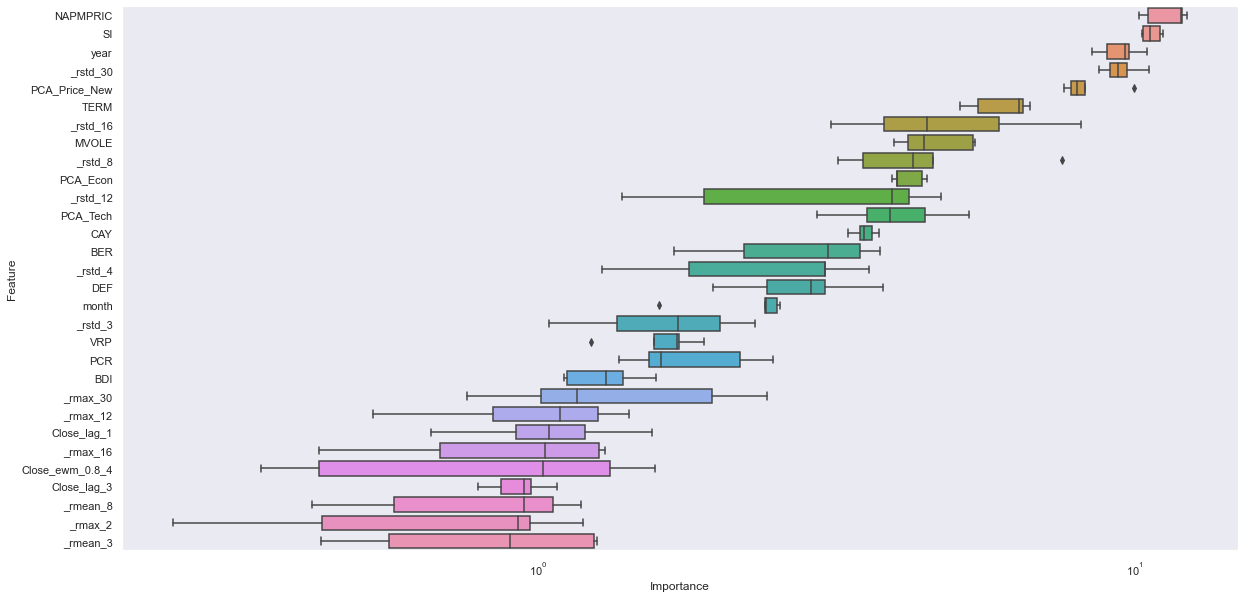

In [64]:
importances = list()
for i in range(5):
    model = joblib.load(f"./trained_model_fold{i}.pkl")
    importances.append(model.feature_importance(importance_type='gain'))
plot_importance(np.array(importances),features, PLOT_TOP_N = 30, figsize=(20, 10))

In [65]:
def predict_y(model, X, y, tr_num, test_num):
    all_pred = list()
    all_y = list()
    for i in tqdm(range(int(len(X.iloc[tr_num:])/test_num))):
        print('Train data num: {}'.format(tr_num))
        print('Test data num: {}'.format(test_num))
        num = i * test_num
        train_X = X.iloc[num:tr_num+num, 1:].values
        train_y = y.iloc[num:tr_num+num].values
        test_X = X.iloc[tr_num+num:tr_num+num+test_num, 1:].values
        test_y = y.iloc[tr_num+num:tr_num+num+test_num].values
        if num % 22 == 0:
             model.fit(train_X, train_y)
        y_pred = model.predict(test_X)
        # print(y_pred)
        try:
            all_pred.extend(list(y_pred[0]))
        except:
            all_pred.append(y_pred[0])
        all_y.extend(test_y)
    return all_pred, all_y

In [66]:
# l = pd.DataFrame()
# l['Date'] = X.iloc[2600:7256]['Date']
# l['lgbm_pred'] = all_pred
# l.to_csv('./lgbm_pred.csv', index=0)

### 2.2 Kitchen Sinking Regression

In [67]:
lr = LinearRegression()
lr_pred, _ = predict_y(lr, X, y, 2600, 1)

  0%|          | 20/4548 [00:00<00:22, 199.99it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

  1%|▏         | 60/4548 [00:00<00:22, 198.98it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

  2%|▏         | 98/4548 [00:00<00:23, 191.19it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

  3%|▎         | 136/4548 [00:00<00:25, 173.71it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

  3%|▎         | 155/4548 [00:00<00:24, 176.80it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

  5%|▍         | 221/4548 [00:01<00:22, 193.58it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

  5%|▌         | 245/4548 [00:01<00:21, 204.45it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

  6%|▋         | 287/4548 [00:01<00:21, 200.88it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

  7%|▋         | 309/4548 [00:01<00:21, 193.22it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


  8%|▊         | 353/4548 [00:01<00:22, 187.95it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

  9%|▉         | 419/4548 [00:02<00:20, 200.74it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 10%|▉         | 441/4548 [00:02<00:20, 201.62it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 11%|█         | 485/4548 [00:02<00:21, 191.25it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 11%|█         | 507/4548 [00:02<00:21, 189.29it/s]


Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data 

 12%|█▏        | 551/4548 [00:02<00:20, 192.92it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 13%|█▎        | 595/4548 [00:03<00:19, 198.10it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 14%|█▍        | 639/4548 [00:03<00:20, 189.74it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 15%|█▍        | 661/4548 [00:03<00:20, 189.23it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 16%|█▌        | 705/4548 [00:03<00:19, 193.70it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 16%|█▋        | 749/4548 [00:03<00:19, 192.88it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 17%|█▋        | 794/4548 [00:04<00:18, 206.68it/s]

Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data nu

 18%|█▊        | 815/4548 [00:04<00:18, 202.26it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 19%|█▉        | 859/4548 [00:04<00:17, 206.22it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 20%|█▉        | 903/4548 [00:04<00:18, 193.21it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 21%|██        | 947/4548 [00:04<00:18, 192.86it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 22%|██▏       | 991/4548 [00:05<00:17, 197.92it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 23%|██▎       | 1035/4548 [00:05<00:18, 186.58it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 23%|██▎       | 1057/4548 [00:05<00:18, 193.42it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 25%|██▍       | 1123/4548 [00:05<00:16, 204.01it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 25%|██▌       | 1145/4548 [00:05<00:16, 203.04it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 26%|██▌       | 1191/4548 [00:06<00:15, 213.93it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 27%|██▋       | 1242/4548 [00:06<00:14, 231.14it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 28%|██▊       | 1291/4548 [00:06<00:14, 230.66it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 29%|██▉       | 1338/4548 [00:06<00:14, 214.34it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 30%|███       | 1384/4548 [00:06<00:14, 211.88it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 31%|███▏      | 1428/4548 [00:07<00:14, 210.31it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 32%|███▏      | 1453/4548 [00:07<00:15, 198.71it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 33%|███▎      | 1497/4548 [00:07<00:15, 202.64it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 34%|███▍      | 1541/4548 [00:07<00:15, 199.74it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 35%|███▍      | 1585/4548 [00:07<00:15, 194.77it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 35%|███▌      | 1607/4548 [00:08<00:14, 196.31it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 36%|███▋      | 1651/4548 [00:08<00:15, 182.64it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 37%|███▋      | 1673/4548 [00:08<00:15, 190.44it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 38%|███▊      | 1717/4548 [00:08<00:14, 191.92it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 39%|███▊      | 1761/4548 [00:08<00:14, 196.85it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 40%|███▉      | 1805/4548 [00:09<00:14, 189.98it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 40%|████      | 1827/4548 [00:09<00:13, 197.03it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 41%|████      | 1871/4548 [00:09<00:14, 180.24it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 42%|████▏     | 1915/4548 [00:09<00:13, 191.61it/s]

Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data nu

 43%|████▎     | 1937/4548 [00:09<00:13, 196.66it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 44%|████▎     | 1981/4548 [00:10<00:13, 193.58it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 45%|████▍     | 2025/4548 [00:10<00:12, 197.90it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 45%|████▌     | 2069/4548 [00:10<00:12, 201.22it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 46%|████▋     | 2113/4548 [00:10<00:11, 206.59it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 47%|████▋     | 2157/4548 [00:10<00:12, 185.09it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600

 48%|████▊     | 2181/4548 [00:11<00:11, 197.75it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 49%|████▉     | 2224/4548 [00:11<00:11, 201.92it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 50%|████▉     | 2273/4548 [00:11<00:10, 219.37it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 51%|█████     | 2319/4548 [00:11<00:10, 220.66it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 52%|█████▏    | 2367/4548 [00:11<00:09, 219.99it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 53%|█████▎    | 2413/4548 [00:12<00:10, 209.55it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 54%|█████▍    | 2460/4548 [00:12<00:09, 218.82it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 55%|█████▌    | 2507/4548 [00:12<00:09, 221.27it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 56%|█████▌    | 2530/4548 [00:12<00:09, 219.97it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 57%|█████▋    | 2575/4548 [00:12<00:09, 202.77it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 58%|█████▊    | 2619/4548 [00:13<00:09, 192.92it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 59%|█████▊    | 2664/4548 [00:13<00:09, 207.15it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 60%|█████▉    | 2712/4548 [00:13<00:08, 219.57it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 61%|██████    | 2758/4548 [00:13<00:08, 222.10it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 62%|██████▏   | 2805/4548 [00:13<00:07, 218.48it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 63%|██████▎   | 2853/4548 [00:14<00:07, 227.38it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 64%|██████▍   | 2903/4548 [00:14<00:07, 228.76it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 65%|██████▍   | 2949/4548 [00:14<00:09, 177.53it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 66%|██████▌   | 2993/4548 [00:14<00:08, 184.71it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 67%|██████▋   | 3039/4548 [00:15<00:07, 203.31it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 68%|██████▊   | 3084/4548 [00:15<00:06, 212.19it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 68%|██████▊   | 3107/4548 [00:15<00:06, 216.02it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 69%|██████▉   | 3149/4548 [00:15<00:07, 181.49it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 70%|███████   | 3195/4548 [00:15<00:06, 203.50it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 71%|███████▏  | 3244/4548 [00:16<00:05, 219.19it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 72%|███████▏  | 3290/4548 [00:16<00:06, 191.93it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 73%|███████▎  | 3313/4548 [00:16<00:06, 200.90it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 74%|███████▍  | 3363/4548 [00:16<00:05, 221.59it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 75%|███████▌  | 3412/4548 [00:16<00:05, 198.78it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 76%|███████▌  | 3434/4548 [00:17<00:05, 203.01it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 77%|███████▋  | 3481/4548 [00:17<00:04, 215.11it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 78%|███████▊  | 3527/4548 [00:17<00:04, 222.62it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 79%|███████▊  | 3575/4548 [00:17<00:04, 230.02it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 80%|███████▉  | 3624/4548 [00:17<00:03, 237.31it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 81%|████████  | 3674/4548 [00:18<00:03, 240.31it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 81%|████████▏ | 3699/4548 [00:18<00:04, 211.65it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 82%|████████▏ | 3744/4548 [00:18<00:03, 217.74it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 83%|████████▎ | 3788/4548 [00:18<00:03, 200.59it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 84%|████████▍ | 3832/4548 [00:18<00:03, 200.67it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 85%|████████▌ | 3874/4548 [00:19<00:03, 188.64it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 86%|████████▌ | 3895/4548 [00:19<00:03, 190.34it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 87%|████████▋ | 3939/4548 [00:19<00:03, 201.49it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 88%|████████▊ | 3985/4548 [00:19<00:02, 206.90it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 89%|████████▊ | 4027/4548 [00:19<00:02, 202.15it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 90%|████████▉ | 4072/4548 [00:20<00:02, 202.80it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 91%|█████████ | 4118/4548 [00:20<00:02, 196.61it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 91%|█████████ | 4139/4548 [00:20<00:02, 170.53it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600

 92%|█████████▏| 4175/4548 [00:20<00:02, 150.07it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 92%|█████████▏| 4191/4548 [00:20<00:02, 150.75it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 93%|█████████▎| 4225/4548 [00:21<00:02, 144.13it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 93%|█████████▎| 4247/4548 [00:21<00:02, 148.10it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 94%|█████████▍| 4291/4548 [00:21<00:01, 159.73it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 95%|█████████▌| 4335/4548 [00:21<00:01, 174.45it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 96%|█████████▌| 4357/4548 [00:21<00:01, 174.91it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 97%|█████████▋| 4401/4548 [00:22<00:00, 179.33it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 98%|█████████▊| 4445/4548 [00:22<00:00, 186.45it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 99%|█████████▊| 4489/4548 [00:22<00:00, 198.21it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 99%|█████████▉| 4511/4548 [00:22<00:00, 203.72it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

100%|██████████| 4548/4548 [00:22<00:00, 200.36it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


lr rmse: 0.008316775825704753
lr r sqaure: 0.29996880781949187


<AxesSubplot:xlabel='Date', ylabel='value'>

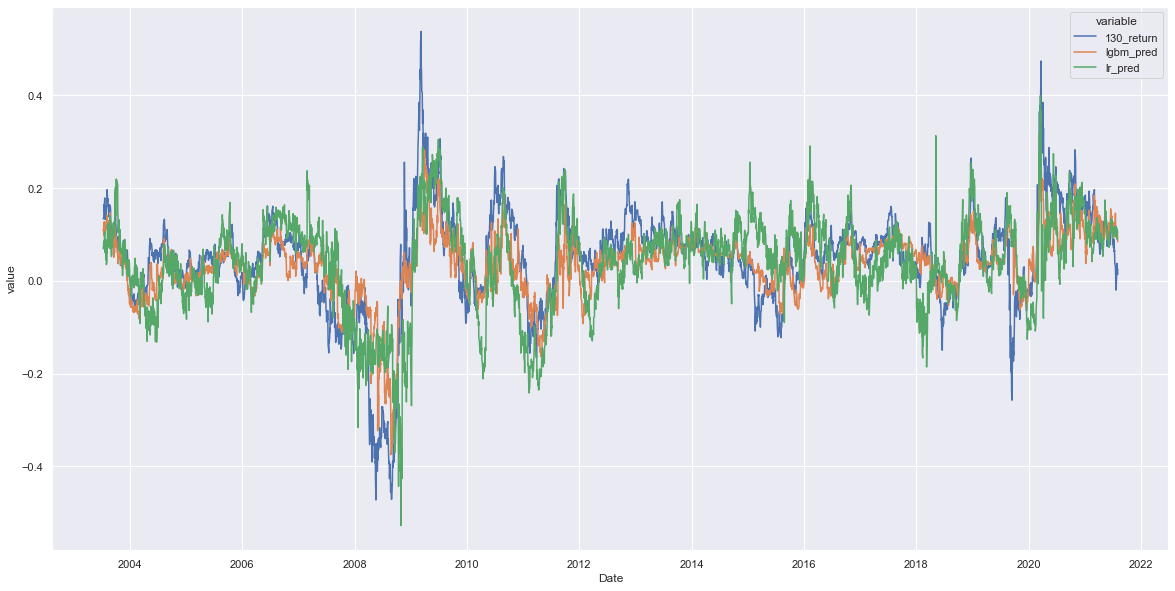

In [68]:
# tmp = y.iloc[6000:7256].copy()
# tmp = pd.DataFrame()
# tmp['22_return'] = list(y.iloc[6000:7254].values)
tmp['lr_pred'] = lr_pred
lr_rmse = mse(all_y, lr_pred)
lr_r2 = r2_score(all_y, lr_pred)
print('lr rmse: {}'.format(lr_rmse))
print('lr r sqaure: {}'.format(lr_r2))
ml = pd.melt(tmp, id_vars=['Date'])
plt.figure(figsize=(20, 10))
sns.lineplot(data=ml, x='Date', y='value', hue='variable')

### 2.3 Correlation Screening

In [69]:
corr = sorted(abs(round(pd.concat([X, y], axis=1).corr()['130_return'], 3)).items(), key=lambda x: x[1], reverse=True)

In [70]:
X_cs = X[[c[0] for c in corr[1:31]]]
cs = LinearRegression()
cs_pred, _ = predict_y(cs, X_cs, y, 2600, 1)

  2%|▏         | 73/4548 [00:00<00:06, 722.77it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

  5%|▍         | 205/4548 [00:00<00:06, 650.65it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

  8%|▊         | 355/4548 [00:00<00:06, 694.50it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 11%|█         | 488/4548 [00:00<00:05, 680.26it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 14%|█▍        | 638/4548 [00:00<00:05, 712.71it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 17%|█▋        | 788/4548 [00:01<00:05, 729.07it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 19%|█▉        | 860/4548 [00:01<00:05, 719.69it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 22%|██▏       | 1009/4548 [00:01<00:04, 727.39it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 26%|██▌       | 1162/4548 [00:01<00:04, 742.82it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 29%|██▉       | 1317/4548 [00:01<00:04, 757.59it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 32%|███▏      | 1468/4548 [00:02<00:04, 747.88it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 36%|███▌      | 1621/4548 [00:02<00:03, 750.73it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 37%|███▋      | 1697/4548 [00:02<00:03, 749.03it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 41%|████      | 1850/4548 [00:02<00:03, 752.09it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 44%|████▍     | 2003/4548 [00:02<00:03, 741.11it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 47%|████▋     | 2157/4548 [00:02<00:03, 744.79it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 49%|████▉     | 2233/4548 [00:03<00:03, 749.29it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 52%|█████▏    | 2380/4548 [00:03<00:03, 691.65it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 56%|█████▌    | 2531/4548 [00:03<00:02, 712.20it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 59%|█████▉    | 2685/4548 [00:03<00:02, 731.26it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 62%|██████▏   | 2838/4548 [00:03<00:02, 747.67it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 66%|██████▌   | 2991/4548 [00:04<00:02, 745.92it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 67%|██████▋   | 3066/4548 [00:04<00:01, 744.91it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 71%|███████   | 3219/4548 [00:04<00:01, 737.55it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 74%|███████▍  | 3368/4548 [00:04<00:01, 734.94it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 77%|███████▋  | 3521/4548 [00:04<00:01, 741.86it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 81%|████████  | 3671/4548 [00:05<00:01, 730.72it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 84%|████████▍ | 3823/4548 [00:05<00:00, 740.02it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

 86%|████████▌ | 3898/4548 [00:05<00:00, 734.25it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 89%|████████▉ | 4052/4548 [00:05<00:00, 740.07it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 92%|█████████▏| 4201/4548 [00:05<00:00, 735.32it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 96%|█████████▌| 4352/4548 [00:05<00:00, 741.10it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data n

 99%|█████████▉| 4506/4548 [00:06<00:00, 755.44it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data n

100%|██████████| 4548/4548 [00:06<00:00, 732.06it/s]


Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


cs rmse: 0.007754335958259599
cs r sqaure: 0.3473099240391435


<AxesSubplot:xlabel='Date', ylabel='value'>

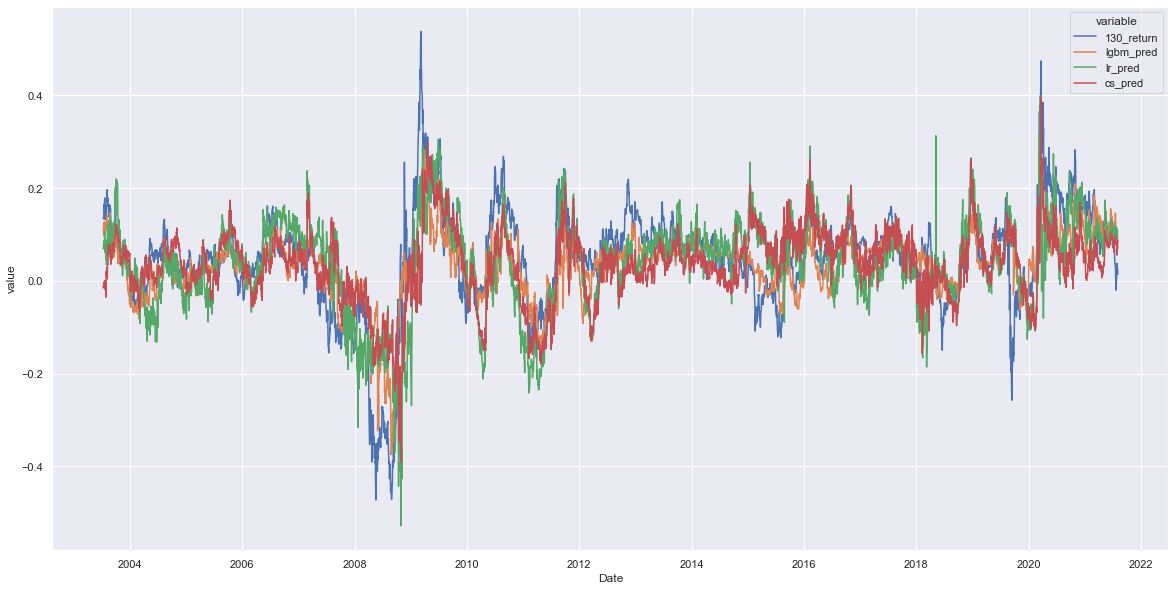

In [71]:
tmp['cs_pred'] = cs_pred
cs_rmse = mse(all_y, cs_pred)
cs_r2 = r2_score(all_y, cs_pred)
print('cs rmse: {}'.format(cs_rmse))
print('cs r sqaure: {}'.format(cs_r2))
ml = pd.melt(tmp, id_vars=['Date'])
plt.figure(figsize=(20, 10))
sns.lineplot(data=ml, x='Date', y='value', hue='variable')

### 2.4 LASSO Regression

In [72]:
# X_col = var.columns.drop(['1MReturn', '3MReturn', '6MReturn', '1YReturn'])
# X_scaled = std_slc.fit_transform(X.iloc[:, 1:])
# X_scaled = pd.DataFrame(data = X_scaled, columns = X.iloc[:, 1:].columns)

# cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
cv = KFold(n_splits=5, random_state = 2021, shuffle = True)
lasso_alphas = np.linspace(0.01, 0, 20)
lasso = LassoCV(alphas=lasso_alphas, cv=cv, n_jobs=-1)
# lasso_pred = []
# predict_y(lasso, lasso_pred, X_scaled)
lasso_pred, _ = predict_y(lasso, X, y, 2600, 1)

  0%|          | 0/4548 [00:00<?, ?it/s]

Train data num: 2600
Test data num: 1


  0%|          | 1/4548 [00:00<23:52,  3.17it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


  1%|          | 23/4548 [00:00<16:58,  4.44it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


  1%|          | 45/4548 [00:00<12:10,  6.17it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


  1%|▏         | 67/4548 [00:01<08:48,  8.48it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


  2%|▏         | 89/4548 [00:01<06:28, 11.46it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


  2%|▏         | 111/4548 [00:01<04:51, 15.22it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


  3%|▎         | 133/4548 [00:02<03:44, 19.67it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


  3%|▎         | 155/4548 [00:02<02:56, 24.83it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


  4%|▍         | 177/4548 [00:03<02:21, 30.81it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


  4%|▍         | 199/4548 [00:03<01:59, 36.25it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


  5%|▍         | 221/4548 [00:03<01:43, 42.00it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


  5%|▌         | 243/4548 [00:04<01:31, 46.94it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


  6%|▌         | 265/4548 [00:04<01:24, 50.95it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


  6%|▋         | 287/4548 [00:04<01:22, 51.63it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


  7%|▋         | 309/4548 [00:05<01:18, 53.90it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


  7%|▋         | 331/4548 [00:05<01:14, 56.98it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


  8%|▊         | 353/4548 [00:05<01:12, 57.48it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


  8%|▊         | 375/4548 [00:06<01:11, 58.50it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


  9%|▊         | 397/4548 [00:06<01:07, 61.47it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


  9%|▉         | 419/4548 [00:06<01:07, 61.62it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 10%|▉         | 441/4548 [00:07<01:05, 63.00it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 10%|█         | 463/4548 [00:07<01:06, 61.21it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 11%|█         | 485/4548 [00:07<01:04, 63.02it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 11%|█         | 507/4548 [00:08<01:04, 62.70it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 12%|█▏        | 529/4548 [00:08<01:03, 63.34it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 12%|█▏        | 551/4548 [00:08<01:02, 63.60it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 13%|█▎        | 573/4548 [00:09<01:01, 65.12it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 13%|█▎        | 595/4548 [00:09<01:00, 64.85it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 14%|█▎        | 617/4548 [00:10<01:02, 63.19it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 14%|█▍        | 639/4548 [00:10<01:02, 62.18it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 15%|█▍        | 661/4548 [00:10<01:01, 63.21it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 15%|█▌        | 683/4548 [00:11<01:01, 62.41it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 16%|█▌        | 705/4548 [00:11<01:00, 63.02it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 16%|█▌        | 727/4548 [00:11<00:58, 64.81it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 16%|█▋        | 749/4548 [00:12<01:00, 62.78it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 17%|█▋        | 771/4548 [00:12<00:58, 64.18it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 17%|█▋        | 793/4548 [00:12<00:58, 64.67it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 18%|█▊        | 815/4548 [00:13<00:57, 64.91it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 18%|█▊        | 837/4548 [00:13<00:57, 64.06it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 19%|█▉        | 859/4548 [00:13<00:57, 64.59it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 19%|█▉        | 881/4548 [00:14<00:57, 63.67it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 20%|█▉        | 903/4548 [00:14<00:55, 65.93it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 20%|██        | 925/4548 [00:14<00:55, 64.98it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 21%|██        | 947/4548 [00:15<00:56, 63.99it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 21%|██▏       | 969/4548 [00:15<00:55, 64.43it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 22%|██▏       | 991/4548 [00:15<00:54, 64.72it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 22%|██▏       | 1013/4548 [00:16<00:54, 64.43it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 23%|██▎       | 1035/4548 [00:16<00:53, 65.08it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 23%|██▎       | 1057/4548 [00:16<00:53, 65.20it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 24%|██▎       | 1079/4548 [00:17<00:53, 64.31it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 24%|██▍       | 1101/4548 [00:17<00:53, 64.65it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 25%|██▍       | 1123/4548 [00:17<00:52, 65.27it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 25%|██▌       | 1145/4548 [00:18<00:51, 65.89it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 26%|██▌       | 1167/4548 [00:18<00:52, 64.66it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 26%|██▌       | 1189/4548 [00:18<00:51, 65.33it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 27%|██▋       | 1211/4548 [00:19<00:51, 65.03it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 27%|██▋       | 1233/4548 [00:19<00:51, 63.85it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 28%|██▊       | 1255/4548 [00:19<00:51, 64.38it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 28%|██▊       | 1277/4548 [00:20<00:51, 64.08it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 29%|██▊       | 1299/4548 [00:20<00:55, 58.42it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 29%|██▉       | 1321/4548 [00:21<00:53, 59.88it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 30%|██▉       | 1343/4548 [00:21<00:51, 62.08it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 30%|███       | 1365/4548 [00:21<00:49, 63.71it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 30%|███       | 1387/4548 [00:22<00:50, 63.13it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 31%|███       | 1409/4548 [00:22<00:48, 64.21it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 31%|███▏      | 1431/4548 [00:22<00:48, 64.92it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 32%|███▏      | 1453/4548 [00:23<00:49, 62.80it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 32%|███▏      | 1475/4548 [00:23<00:47, 64.19it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 33%|███▎      | 1497/4548 [00:23<00:47, 64.46it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 33%|███▎      | 1519/4548 [00:24<00:45, 66.03it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 34%|███▍      | 1541/4548 [00:24<00:46, 65.10it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 34%|███▍      | 1563/4548 [00:24<00:45, 65.62it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 35%|███▍      | 1585/4548 [00:25<00:45, 64.54it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 35%|███▌      | 1607/4548 [00:25<00:44, 65.39it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 36%|███▌      | 1629/4548 [00:25<00:45, 63.85it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 36%|███▋      | 1651/4548 [00:26<00:44, 64.44it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 37%|███▋      | 1673/4548 [00:26<00:43, 66.48it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 37%|███▋      | 1695/4548 [00:26<00:42, 66.90it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 38%|███▊      | 1717/4548 [00:27<00:44, 64.31it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 38%|███▊      | 1739/4548 [00:27<00:43, 64.48it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 39%|███▊      | 1761/4548 [00:27<00:43, 64.63it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 39%|███▉      | 1783/4548 [00:28<00:43, 63.76it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 40%|███▉      | 1805/4548 [00:28<00:42, 64.60it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 40%|████      | 1827/4548 [00:28<00:43, 62.19it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 41%|████      | 1849/4548 [00:29<00:42, 63.91it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 41%|████      | 1871/4548 [00:29<00:41, 63.93it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 42%|████▏     | 1893/4548 [00:29<00:41, 64.50it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 42%|████▏     | 1915/4548 [00:30<00:40, 64.50it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 43%|████▎     | 1937/4548 [00:30<00:39, 66.75it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 43%|████▎     | 1959/4548 [00:30<00:40, 64.55it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 44%|████▎     | 1981/4548 [00:31<00:39, 64.48it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 44%|████▍     | 2003/4548 [00:31<00:40, 63.16it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 45%|████▍     | 2025/4548 [00:31<00:40, 62.66it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 45%|████▌     | 2047/4548 [00:32<00:39, 63.10it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 45%|████▌     | 2069/4548 [00:32<00:38, 64.38it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 46%|████▌     | 2091/4548 [00:32<00:38, 63.31it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 46%|████▋     | 2113/4548 [00:33<00:38, 62.49it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 47%|████▋     | 2135/4548 [00:33<00:38, 62.50it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 47%|████▋     | 2157/4548 [00:34<00:38, 62.80it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 48%|████▊     | 2179/4548 [00:34<00:37, 62.61it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 48%|████▊     | 2201/4548 [00:34<00:37, 63.27it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 49%|████▉     | 2223/4548 [00:35<00:37, 61.20it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 49%|████▉     | 2245/4548 [00:35<00:36, 62.69it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 50%|████▉     | 2267/4548 [00:35<00:36, 62.77it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 50%|█████     | 2289/4548 [00:36<00:35, 63.62it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 51%|█████     | 2311/4548 [00:36<00:35, 63.11it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 51%|█████▏    | 2333/4548 [00:36<00:35, 63.09it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 52%|█████▏    | 2355/4548 [00:37<00:36, 60.56it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 52%|█████▏    | 2377/4548 [00:37<00:35, 61.30it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 53%|█████▎    | 2399/4548 [00:37<00:34, 62.23it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 53%|█████▎    | 2421/4548 [00:38<00:33, 62.85it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 54%|█████▎    | 2443/4548 [00:38<00:33, 63.50it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 54%|█████▍    | 2465/4548 [00:38<00:33, 62.76it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 55%|█████▍    | 2487/4548 [00:39<00:33, 62.26it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 55%|█████▌    | 2509/4548 [00:39<00:32, 63.03it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 56%|█████▌    | 2531/4548 [00:40<00:32, 62.54it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 56%|█████▌    | 2553/4548 [00:40<00:31, 63.36it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 57%|█████▋    | 2575/4548 [00:40<00:31, 62.45it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 57%|█████▋    | 2597/4548 [00:41<00:32, 60.51it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 58%|█████▊    | 2619/4548 [00:41<00:30, 63.12it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 58%|█████▊    | 2641/4548 [00:41<00:30, 62.40it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 59%|█████▊    | 2663/4548 [00:42<00:30, 62.44it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 59%|█████▉    | 2685/4548 [00:42<00:29, 62.14it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 60%|█████▉    | 2707/4548 [00:42<00:29, 61.67it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 60%|██████    | 2729/4548 [00:43<00:30, 60.59it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 60%|██████    | 2751/4548 [00:43<00:28, 62.56it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 61%|██████    | 2773/4548 [00:43<00:28, 62.06it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 61%|██████▏   | 2795/4548 [00:44<00:28, 62.01it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 62%|██████▏   | 2817/4548 [00:44<00:27, 63.20it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 62%|██████▏   | 2839/4548 [00:44<00:26, 63.48it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 63%|██████▎   | 2861/4548 [00:45<00:26, 63.62it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 63%|██████▎   | 2883/4548 [00:45<00:25, 64.22it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 64%|██████▍   | 2905/4548 [00:45<00:25, 63.80it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 64%|██████▍   | 2927/4548 [00:46<00:25, 64.16it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 65%|██████▍   | 2949/4548 [00:46<00:25, 63.21it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 65%|██████▌   | 2971/4548 [00:47<00:24, 63.82it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 66%|██████▌   | 2993/4548 [00:47<00:25, 61.86it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 66%|██████▋   | 3015/4548 [00:47<00:24, 63.27it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 67%|██████▋   | 3037/4548 [00:48<00:24, 61.45it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 67%|██████▋   | 3059/4548 [00:48<00:24, 60.94it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 68%|██████▊   | 3081/4548 [00:48<00:23, 61.54it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 68%|██████▊   | 3103/4548 [00:49<00:23, 61.30it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 69%|██████▊   | 3125/4548 [00:49<00:23, 60.44it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 69%|██████▉   | 3147/4548 [00:49<00:22, 61.34it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 70%|██████▉   | 3169/4548 [00:50<00:22, 61.53it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 70%|███████   | 3191/4548 [00:50<00:22, 61.31it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 71%|███████   | 3213/4548 [00:51<00:21, 60.97it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 71%|███████   | 3235/4548 [00:51<00:22, 58.90it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 72%|███████▏  | 3257/4548 [00:51<00:22, 57.70it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 72%|███████▏  | 3279/4548 [00:52<00:22, 55.87it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 73%|███████▎  | 3301/4548 [00:52<00:21, 57.48it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 73%|███████▎  | 3323/4548 [00:53<00:21, 55.86it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 74%|███████▎  | 3345/4548 [00:53<00:20, 58.08it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 74%|███████▍  | 3367/4548 [00:53<00:20, 58.33it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 75%|███████▍  | 3389/4548 [00:54<00:19, 59.18it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 75%|███████▌  | 3411/4548 [00:54<00:19, 59.84it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 75%|███████▌  | 3433/4548 [00:54<00:19, 58.31it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 76%|███████▌  | 3455/4548 [00:55<00:18, 58.44it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 76%|███████▋  | 3477/4548 [00:55<00:18, 57.84it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 77%|███████▋  | 3499/4548 [00:55<00:17, 58.31it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 77%|███████▋  | 3521/4548 [00:56<00:17, 59.21it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 78%|███████▊  | 3543/4548 [00:56<00:17, 58.13it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 78%|███████▊  | 3565/4548 [00:57<00:17, 55.93it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 79%|███████▉  | 3587/4548 [00:57<00:16, 57.21it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 79%|███████▉  | 3609/4548 [00:57<00:16, 56.17it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 80%|███████▉  | 3631/4548 [00:58<00:16, 56.76it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 80%|████████  | 3653/4548 [00:58<00:15, 58.70it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 81%|████████  | 3675/4548 [00:59<00:14, 59.50it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 81%|████████▏ | 3697/4548 [00:59<00:14, 58.58it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 82%|████████▏ | 3719/4548 [00:59<00:13, 59.51it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 82%|████████▏ | 3741/4548 [01:00<00:13, 60.63it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 83%|████████▎ | 3763/4548 [01:00<00:12, 61.46it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 83%|████████▎ | 3785/4548 [01:00<00:11, 63.92it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 84%|████████▎ | 3807/4548 [01:01<00:11, 62.57it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 84%|████████▍ | 3829/4548 [01:01<00:11, 61.51it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 85%|████████▍ | 3851/4548 [01:01<00:11, 62.20it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 85%|████████▌ | 3873/4548 [01:02<00:10, 61.61it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 86%|████████▌ | 3895/4548 [01:02<00:10, 63.38it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 86%|████████▌ | 3917/4548 [01:02<00:10, 62.25it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 87%|████████▋ | 3939/4548 [01:03<00:09, 62.06it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 87%|████████▋ | 3961/4548 [01:03<00:09, 61.80it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 88%|████████▊ | 3983/4548 [01:03<00:08, 63.33it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 88%|████████▊ | 4005/4548 [01:04<00:08, 62.49it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 89%|████████▊ | 4027/4548 [01:04<00:08, 63.43it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 89%|████████▉ | 4049/4548 [01:04<00:07, 63.84it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 90%|████████▉ | 4071/4548 [01:05<00:07, 63.44it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 90%|████████▉ | 4093/4548 [01:05<00:07, 62.40it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 90%|█████████ | 4115/4548 [01:06<00:06, 62.72it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 91%|█████████ | 4137/4548 [01:06<00:06, 63.74it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 91%|█████████▏| 4159/4548 [01:06<00:06, 64.22it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 92%|█████████▏| 4181/4548 [01:07<00:05, 63.77it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 92%|█████████▏| 4203/4548 [01:07<00:05, 63.83it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 93%|█████████▎| 4225/4548 [01:07<00:05, 62.88it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 93%|█████████▎| 4247/4548 [01:08<00:04, 64.03it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 94%|█████████▍| 4269/4548 [01:08<00:04, 64.80it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 94%|█████████▍| 4291/4548 [01:08<00:03, 64.60it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 95%|█████████▍| 4313/4548 [01:09<00:03, 63.57it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 95%|█████████▌| 4335/4548 [01:09<00:03, 63.41it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 96%|█████████▌| 4357/4548 [01:09<00:02, 63.68it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 96%|█████████▋| 4379/4548 [01:10<00:02, 61.79it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 97%|█████████▋| 4401/4548 [01:10<00:02, 61.43it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 97%|█████████▋| 4423/4548 [01:10<00:02, 58.05it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 98%|█████████▊| 4445/4548 [01:11<00:01, 59.79it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 98%|█████████▊| 4467/4548 [01:11<00:01, 60.23it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 99%|█████████▊| 4489/4548 [01:12<00:00, 60.66it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


 99%|█████████▉| 4511/4548 [01:12<00:00, 59.65it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


100%|██████████| 4548/4548 [01:12<00:00, 62.45it/s]

Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1
Train data num: 2600
Test data num: 1


lasso rmse: 0.007942009194474747
lasso r sqaure: 0.33151328336475905


<AxesSubplot:xlabel='Date', ylabel='value'>

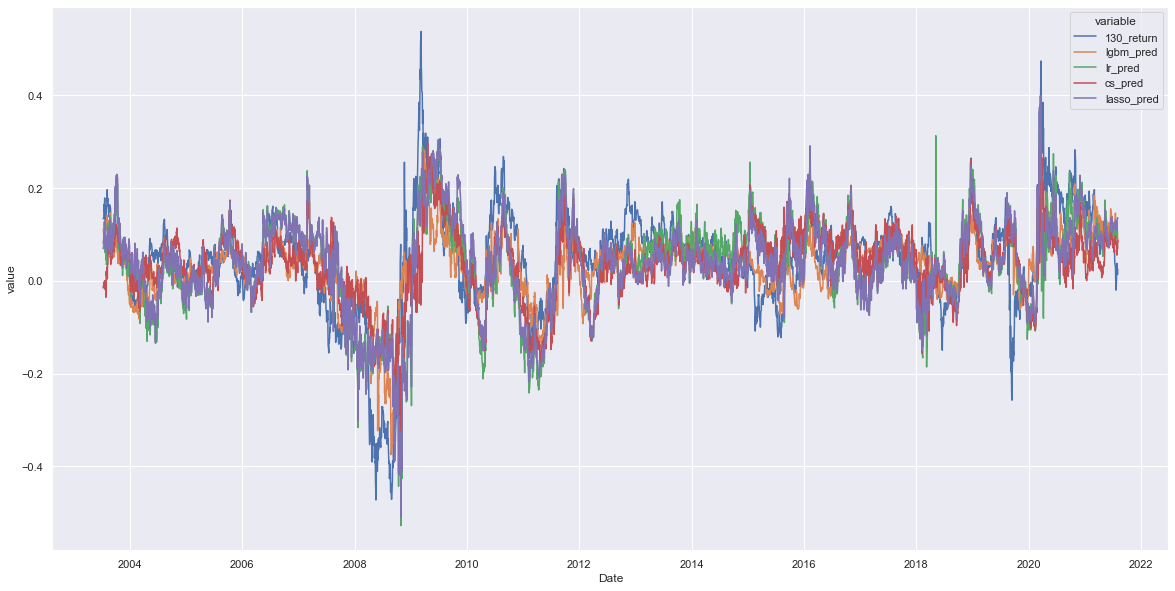

In [73]:
tmp['lasso_pred'] = lasso_pred
lasso_rmse = mse(all_y, lasso_pred)
lasso_r2 = r2_score(all_y, lasso_pred)
print('lasso rmse: {}'.format(lasso_rmse))
print('lasso r sqaure: {}'.format(lasso_r2))
ml = pd.melt(tmp, id_vars=['Date'])
plt.figure(figsize=(20, 10))
sns.lineplot(data=ml, x='Date', y='value', hue='variable')

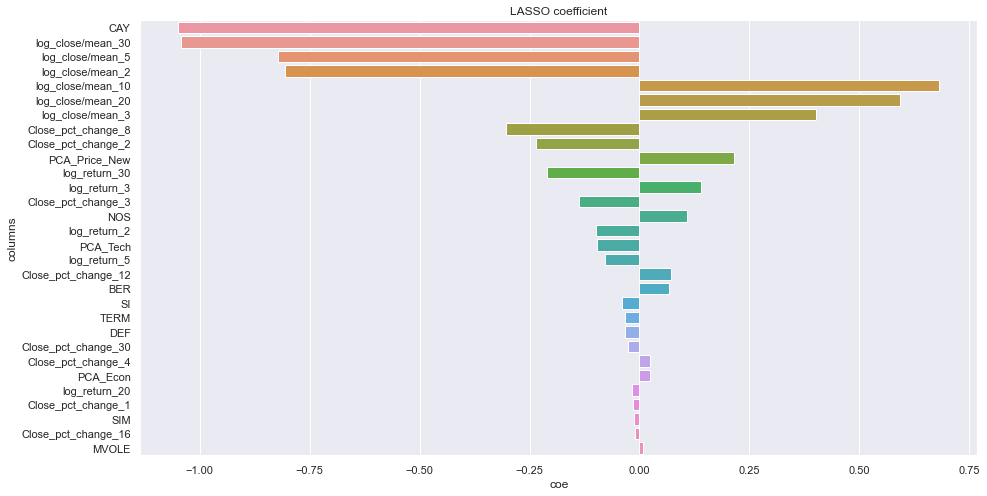

In [74]:
ls  = pd.DataFrame()
ls['coe'] = lasso.coef_
ls['abs_coe'] = abs(lasso.coef_)
ls['columns'] = X.iloc[:, 1:].columns
ls = ls.sort_values(by='abs_coe', ascending=False).iloc[:30]
g = sns.barplot(x="coe", y="columns", data=ls)
g.set_title('LASSO coefficient')
plt.savefig('./figure/lasso_coe.png')

## 3. Actual vs. Forecast Returns

### 3.1 cum_sum

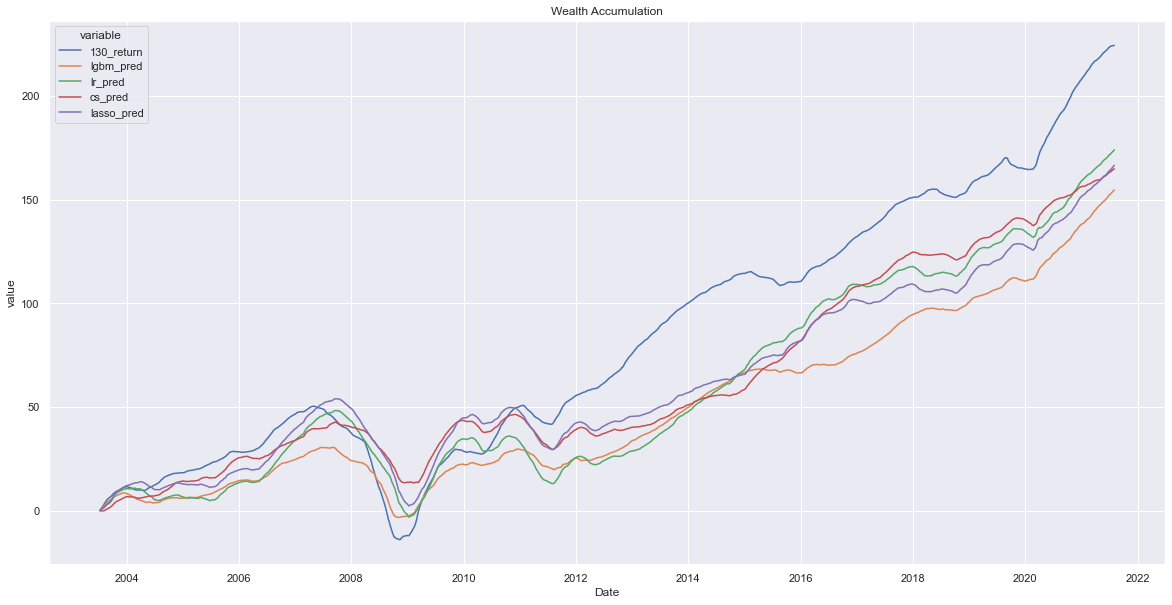

In [75]:
count = tmp.copy()
count = count.drop(['Date'], axis=1).cumsum()
count['Date'] = tmp['Date']
ml_count = pd.melt(count, id_vars=['Date'])
plt.figure(figsize=(20, 10))
g = sns.lineplot(data=ml_count, x='Date', y='value', hue='variable')
g.set_title('Wealth Accumulation')
plt.savefig('./figure/accumulation.png')

### 3.2 RMSE & R2

In [76]:
rr = pd.DataFrame()
rr['model'] = ['LGBM', 'LR', 'CS', 'LASSO']
rr['RMSE'] = [lgbm_rmse, lr_rmse, cs_rmse, lasso_rmse]
rr['R2'] = [lgbm_r2, lr_r2, cs_r2, lasso_r2]
rr

,model,RMSE,R2
0,LGBM,0.004508,0.620559
1,LR,0.008317,0.299969
2,CS,0.007754,0.347310
3,LASSO,0.007942,0.331513


### 3.3 Position(8 times)

In [77]:
def position_plot(df, model_name, color):
    tmp_cp = df[['Date', '130_return', f'{model_name}_pred']].copy()
    plt.figure(figsize=(30, 5))
    tmp_cp[f'{model_name}_pred'] = tmp_cp[f'{model_name}_pred'] * 8
    tmp_cp[f'{model_name}_pred'] = tmp_cp[f'{model_name}_pred'].apply(lambda x: 1.5 if x > 1.5 else x)
    tmp_cp[f'{model_name}_pred'] = tmp_cp[f'{model_name}_pred'].apply(lambda x: -0.5 if x < -0.5 else x)
    g = sns.lineplot(data=tmp_cp, x='Date', y=f'{model_name}_pred', color=f"{color}")
    plt.axhline(y=1, color='black', linestyle='dotted')
    plt.axhline(y=0, color='black', linestyle='dashed')
    g.set_title(f'{model_name.upper()} Position')
    # plt.legend()
    plt.savefig(f'./figure/{model_name}_position.png')

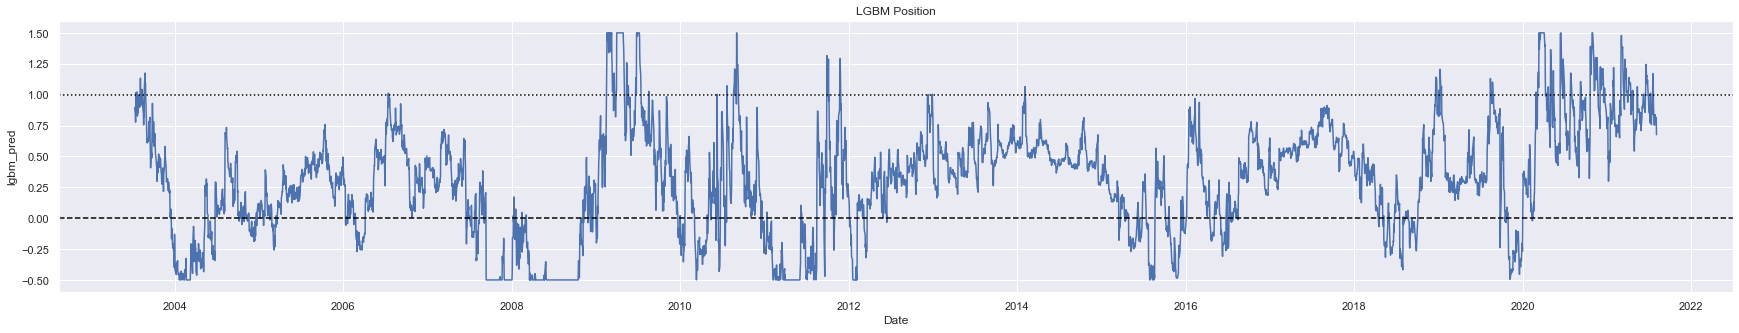

In [78]:
position_plot(tmp, 'lgbm', 'b')

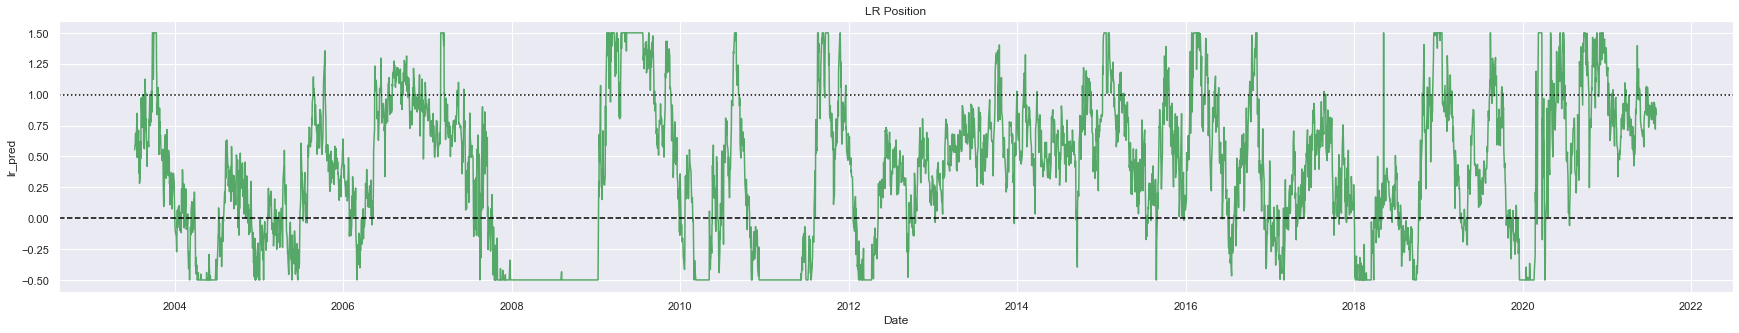

In [79]:
position_plot(tmp, 'lr', 'g')

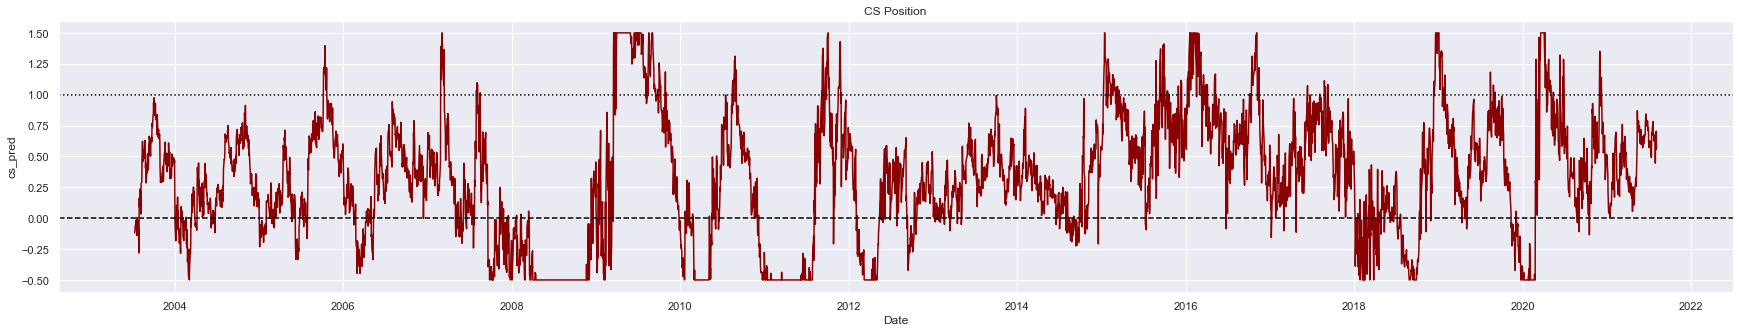

In [80]:
position_plot(tmp, 'cs', 'darkred')

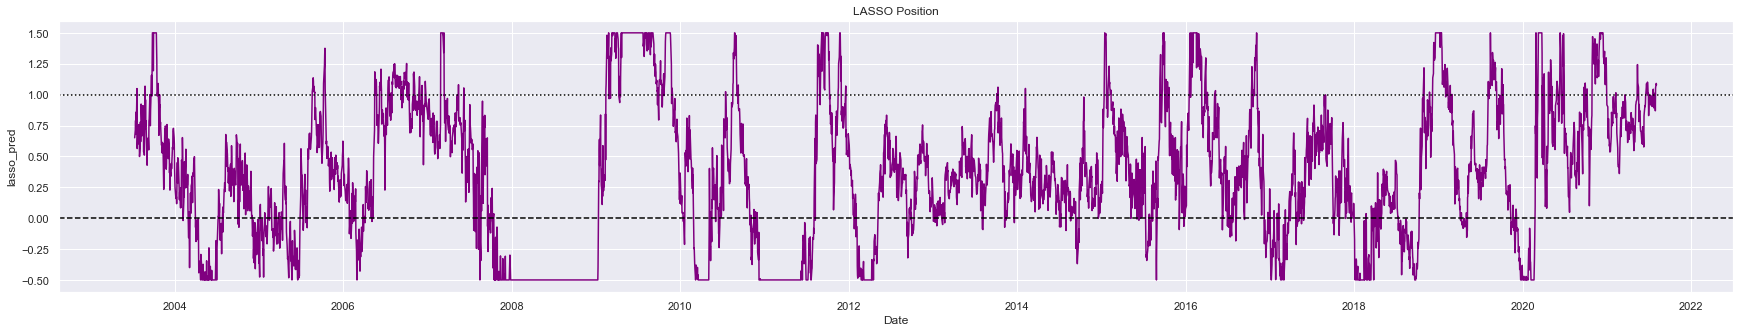

In [81]:
position_plot(tmp, 'lasso', 'purple')

### 3.4 Regplot

In [82]:
def reg_plot(df, model_name, color):
    plt.figure(figsize=(10, 10))
    g = sns.regplot(x="130_return", y=f"{model_name}_pred", data=df,
                    color=f"{color}")
    plt.axis('equal')
    plt.axhline(y=0, color='black', linestyle='dashed')
    plt.axvline(x=0, color='black', linestyle='dashed')
    plt.axline([0, 0], [0.1, 0.1], color='black', linestyle='dashed')
    g.set_title(f'{model_name.upper()} Model')
    plt.savefig(f'./figure/{model_name}_vs.png')

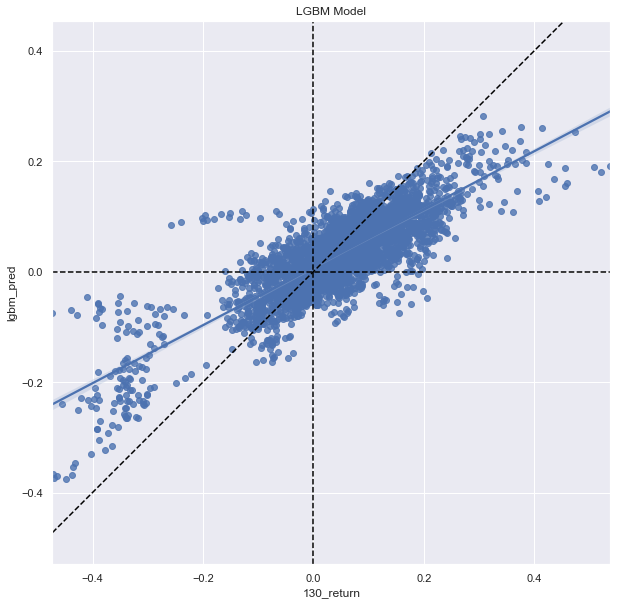

In [83]:
reg_plot(tmp, 'lgbm', 'b')

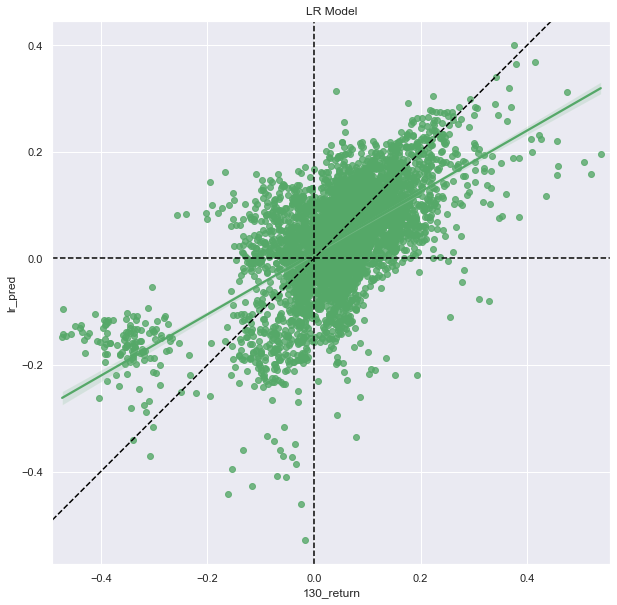

In [84]:
reg_plot(tmp, 'lr', 'g')

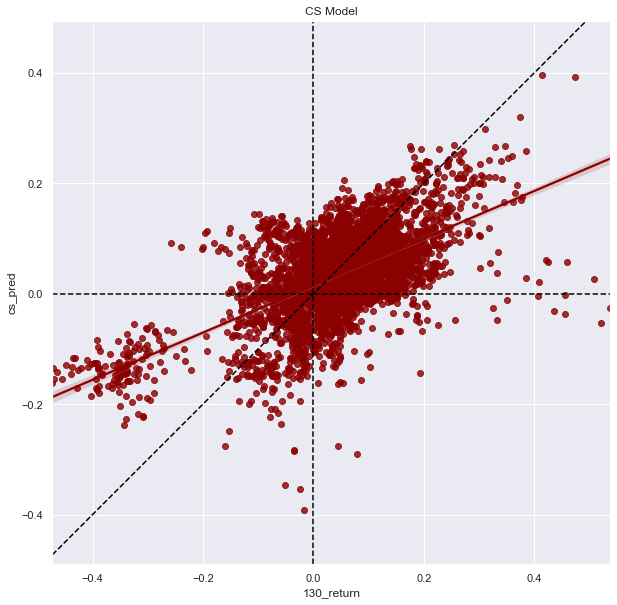

In [85]:
reg_plot(tmp, 'cs', 'darkred')

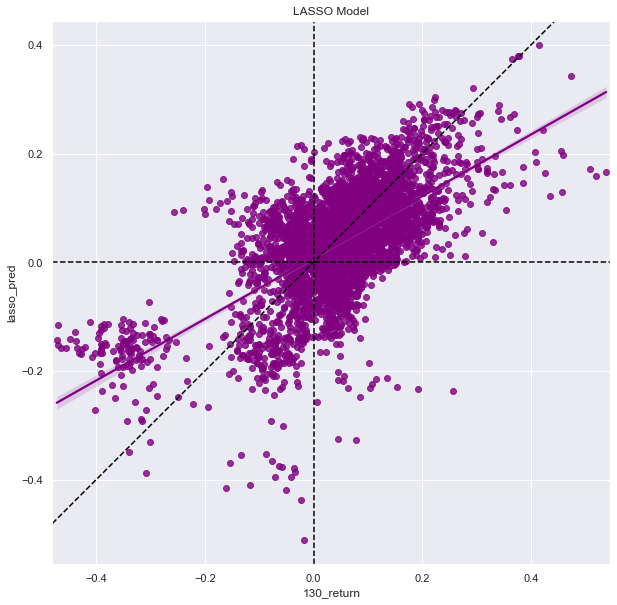

In [252]:
reg_plot(tmp, 'lasso', 'purple')

In [147]:
table = tmp.copy()
table['year'] = tmp['Date'].apply(lambda x: str(x)[0:4])

$Annual\;Return = (\frac{Ending Value}{Begining Value})^{\frac{365}{HoldDays}} - 1$

In [148]:
table['hold_days'] = (data['Date'].shift(-130) - data['Date'])[2630:7178].apply(lambda x: x.days)

In [149]:
def calculate_annual_return(table, model_name):
    df = table.copy()
    df[f'{model_name}_buy'] = table.apply(lambda x: \
        x['130_return'] * x[f'{model_name}_pred'] if x[f'{model_name}_pred'] > 0 else 0, axis=1)
    df[f'{model_name}_ar'] = df.apply(lambda x: \
    ((x[f'{model_name}_buy'] + x[f'{model_name}_pred']) \
        / x[f'{model_name}_pred'])**(365/x['hold_days']) - 1, axis=1)
    return df

In [150]:
table = calculate_annual_return(table, 'lgbm')
table = calculate_annual_return(table, 'lr')
table = calculate_annual_return(table, 'cs')
table = calculate_annual_return(table, 'lasso')

In [151]:
table

,130_return,Date,lgbm_pred,lr_pred,cs_pred,lasso_pred,year,hold_days,lgbm_buy,lgbm_ar,lr_buy,lr_ar,cs_buy,cs_ar,lasso_buy,lasso_ar
2630,0.135076,2003-07-11,0.111687,0.069249,-0.014898,0.081341,2003,188,0.015086,0.278881,0.009354,0.278881,0.000000,0.000000,0.010987,0.278881
2631,0.134022,2003-07-14,0.105063,0.077231,-0.007432,0.089424,2003,186,0.014081,0.279932,0.010351,0.279932,0.000000,0.000000,0.011985,0.279932
2632,0.136205,2003-07-15,0.097199,0.085958,-0.006668,0.098777,2003,189,0.013239,0.279673,0.011708,0.279673,0.000000,0.000000,0.013454,0.279673
2633,0.151922,2003-07-16,0.113229,0.072898,-0.008410,0.084750,2003,189,0.017202,0.314077,0.011075,0.314077,0.000000,0.000000,0.012875,0.314077
2634,0.165482,2003-07-17,0.127073,0.078105,-0.001897,0.107346,2003,189,0.021028,0.344116,0.012925,0.344116,0.000000,0.000000,0.017764,0.344116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7173,0.032177,2021-07-28,0.104725,0.108719,0.083879,0.126656,2021,188,0.003370,0.063416,0.003498,0.063416,0.002699,0.063416,0.004075,0.063416
7174,0.037899,2021-07-29,0.097693,0.090133,0.055688,0.108632,2021,188,0.003702,0.074891,0.003416,0.074891,0.002111,0.074891,0.004117,0.074891
7175,0.018449,2021-07-30,0.102225,0.111661,0.077188,0.131770,2021,188,0.001886,0.036129,0.002060,0.036129,0.001424,0.036129,0.002431,0.036129
7176,0.025389,2021-08-02,0.101569,0.105165,0.088064,0.136343,2021,186,0.002579,0.050431,0.002670,0.050431,0.002236,0.050431,0.003462,0.050431


In [152]:
buy_hold_ar = table.apply(lambda x: \
    ((x['130_return'] + 1) / 1)**(365/x['hold_days']) - 1, axis=1).sum()/len(table)
lgbm_ar = table['lgbm_ar'].sum()/len(table)
lr_ar = table['lr_ar'].sum()/len(table)
cs_ar = table['cs_ar'].sum()/len(table)
lasso_ar = table['lasso_ar'].sum()/len(table)

ar = pd.DataFrame()
ar['strategy'] = ['buy_and_hold', 'LGBM', 'LR', 'CS', 'LASSO']
ar['mean_annual_return'] = [buy_hold_ar, lgbm_ar, lr_ar, cs_ar, lasso_ar]
ar


,strategy,mean_annual_return
0,buy_and_hold,0.108452
1,LGBM,0.133845
2,LR,0.121916
3,CS,0.123376
4,LASSO,0.122460
